<a id="inicio"></a>
# Idealista

1. [Importar librerías](#import)
2. [Definición de Constantes](#constants)
3. [Carga de los datos](#cargadatos)
4. [Análisis exploratorio de los datos y Feature Engineering](#eda_featureengineering)
   - [Descripción de las variables](#variables)
   - [Eliminar duplicados](#duplicados)
   - [Tratamiento de Missings](#nulos)
     - [Tratar barrio y distrito](#barrio_distrito)
     - [Quedarnos sólo con viviendas de Madrid](#solo_madrid)
     - [Tratar resto de variables con nans y que no se van a eliminar](#resto_nans)
   - [Análisis del Target](#analisis_target)
   - [Eliminación de features](#eliminar_features)
   - [Endoding de features](#encoding)
5. [Machine Learning](#machinelearning)
   - [División train-test](#div_train-test)
   - [Selección de Features](#feature_selection)
     - [Análisis de correlación](#analisis_corr)
     - [SelectKBest](#selectkbest)
     - [RandomForestRegressor](#RandomForestRegressor)
     - [Conclusiones Seleccion de Features](#conc_sel_feat) 
   - [Modelado](#modelado)
     - [Decidir qué modelo Machine Learning usar](#select_model)
     - [Evaluar el modelo Machine Learning elegido con test](#evaluate_model)
     - [Predecir nuevas viviendas con el modelo de Machine Learning](#predict_new_ml)
6. [Deep Learning](#deeplearning)
   - [Predecir nuevas viviendas con el modelo de Deep Learning](#predict_new_dl)

 <a id="import"></a>
## Importar librerías

In [3]:
import math
import os
import time
import sys
sys.path.append(r"../")

import pickle

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import utils.idealistatools as idealistatools

[Ir a inicio](#inicio)

 <a id="constants"></a>
## Definición de Constantes

In [1]:
DATA_PATH = "data"
MODELS_PATH = "models"
IMAGES_PATH = "images"

[Ir a inicio](#inicio)

 <a id="cargadatos"></a>
## Carga de los datos

En el notebook **[GetDataIdealista.ipynb](./GetDataIdealista.ipynb)** se obtuvieron datos de *viviendas en venta de Madrid* a través de la API de Idealista, se hizo una preparación inicial de los datos y el Dataset resultante se almacenó en un fichero CSV.   
Debido al número limitado de peticiones que se pueden hacer con la API de Idealista al mes, sólo se ha podido conseguir alrededor de 11 mil muestras.
   
En primer lugar se realiza la carga del Dataset en un DataFrame.

In [4]:
idealista_fe = idealistatools.IdealistaFeatureEngineering(debug = True)

In [5]:
idealista_df = pd.read_csv(os.path.join(DATA_PATH, 'idealista.csv'))
idealista_df

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,topNewDevelopment,newDevelopmentFinished,subTypology,hasParkingSpace,isParkingSpaceIncludedInPrice
0,93868909,https://img3.idealista.com/blur/WEB_LISTING/0/...,lm161734,32,5,690000,flat,sale,130.0,False,...,"{'subtitle': 'Ibiza, Madrid', 'title': 'Piso'}",True,True,False,False,False,NaN,NaN,NaN,NaN
1,93294614,https://img3.idealista.com/blur/WEB_LISTING/0/...,AM159809,40,bj,895000,flat,sale,277.0,True,...,"{'subtitle': 'Arroyo de la Vega, La Moraleja',...",True,True,False,True,False,NaN,NaN,True,True
2,93836396,https://img3.idealista.com/blur/WEB_LISTING/0/...,V6600I,59,NaN,1890000,chalet,sale,401.0,False,...,"{'subtitle': 'Encinar de los Reyes, La Moralej...",True,True,False,True,False,NaN,semidetachedHouse,True,True
3,93242574,https://img3.idealista.com/blur/WEB_LISTING/0/...,MV3938I,51,2,1220000,flat,sale,190.0,True,...,"{'subtitle': 'Almagro, Madrid', 'title': 'Piso'}",True,True,False,True,False,NaN,NaN,True,True
4,93067738,https://img3.idealista.com/blur/WEB_LISTING/0/...,V5343I,49,2,998000,flat,sale,191.0,True,...,"{'subtitle': 'El Soto de la Moraleja, La Moral...",True,True,False,True,False,NaN,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11695,90254228,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM2007009,16,bj,290000,flat,sale,48.0,True,...,"{'subtitle': 'Colina, Madrid', 'title': 'Piso'}",True,False,False,False,False,NaN,NaN,True,True
11696,87878805,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1911049,19,1,850000,flat,sale,160.0,True,...,"{'subtitle': 'Huertas-Cortes, Madrid', 'title'...",True,False,False,False,False,NaN,NaN,NaN,NaN
11697,87375364,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1910036,19,2,1250000,flat,sale,220.0,True,...,"{'subtitle': 'Malasaña-Universidad, Madrid', '...",True,False,False,False,False,NaN,NaN,NaN,NaN
11698,85504146,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1811046,32,4,1950000,flat,sale,289.0,True,...,"{'subtitle': 'Goya, Madrid', 'title': 'Piso'}",False,False,False,False,False,NaN,NaN,NaN,NaN


[Ir a inicio](#inicio)

 <a id="eda2"></a>
### EDA

 <a id="eda_featureengineering"></a>
## Análisis exploratorio de los datos y Feature Engineering

En este apartado sea realiza un EDA (Análisis exploratorio de los datos) para entender bien en contexto del Dataset y sus varaibles (features) para posteriormente hacer un tratamiento y una selección de las variables más importantes a utilizar en los modelos de Machine Learning y Deep Learning. 

In [4]:
idealista_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11700 entries, 0 to 11699
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   propertyCode                   11700 non-null  int64  
 1   thumbnail                      11678 non-null  object 
 2   externalReference              10356 non-null  object 
 3   numPhotos                      11700 non-null  int64  
 4   floor                          9510 non-null   object 
 5   price                          11700 non-null  int64  
 6   propertyType                   11700 non-null  object 
 7   operation                      11700 non-null  object 
 8   size                           11700 non-null  float64
 9   exterior                       11700 non-null  bool   
 10  rooms                          11700 non-null  int64  
 11  bathrooms                      11700 non-null  int64  
 12  address                        11700 non-null 

 <a id="variables"></a>
### Descripción de las variables

- **propertyCode**: código únido que identifica la vivienda
- **thumbnail**: imagen en miniatura del anuncio de Idealista
- **externalReference**: número de referencia externo a Idealista
- **numPhotos**: número de fotos de la vivianda en el anuncio de Idealista
- **floor**: planta
- **price**: precio de venta
- **propertyType**: tipo de propiedad. Posibles valores: 'flat', 'chalet', 'duplex', 'penthouse', 'studio', 'countryHouse'
- **operation**: tipo de operación en la que está la vivienda (venta o alquiler). Posibles valores: 'sale', 'rent'
- **size**: tamaño de la vivienda en m2
- **exterior**: indica su es un piso exterior (True) o interior (False)
- **rooms**: número de habitaciones de la vivienda
- **bathrooms**: número de cuartos de baño de la vivienda
- **address**: dirección de la vivianda
- **province**: provincia en la que se encuantra la vivienda
- **municipality**: municipio en el que se encuantra la vivienda
- **district**: distrito en el que se encuentra la vivienda
- **country**: código del país en el que se encuentra la vivienda  
- **neighborhood**: barrio en el que se encuentra la vivienda
- **latitude** y **longitude**: coordenada geográfica de la vivienda
- **showAddress**: indica si el propietario de la vivienda permite mostrar la dirección en la Web de Idealista
- **url**: url a la página web de Idealista con la ficha de la vivianda
- **distance**: distancia al centro en metros
- **hasVideo**: indica si el anuncio en la web Idealista tiene un vídeo profesional de la vivienda
- **status**: estado de la vivienda. Posibles valores: 'good', 'renew', 'newdevelopment'
- **newDevelopment**: indica si es una nueva construcción
- **hasLift**: indica si tiene ascensor
- **priceByArea**: precio por metro cuadrado
- **suggestedTexts**: diccionario con 2 textos adicionales, título y subtítulo.
- **hasPlan**: indica si el anuncio en la web Idealista tiene un plano de la vivienda
- **has3DTour**: indica si el anuncio en la web Idealista tiene una visita 3D de la vivienda
- **has360**: indica si el anuncio en la web Idealista tiene una vista de 360 grados de la vivienda
- **hasStaging**: indica si el anuncio en la web Idealista tiene *home staging*, que se encarga de realzar el aspecto de la vivienda y de darle una apariencia atractiva
- **topNewDevelopment**: indica si es una nueva construcción en una zona residencial lujosa
- **newDevelopmentFinished**: True si la nueva construcción ha finalizado. NaN si no la finalizado
- **subTypology**: subtipos de cada uno de estos tipos de viviendas:
  - *flats*: duplex, penthouse, studio
  - *chalets*: independantHouse, semidetachedHouse, terracedHouse, andarMoradia
  - *country houses*: countryHouse, castillo, palacio, masia, cortijo, casale, casaDePueblo, casaTerrera, casaMata, torre, caseron, pazo, villa, palacete, masseria, fattoria, trullo, casalicascine, baiteChalet, quinta, moinho, monteAlentejano, solar
  - *premises*: commercialProperty, industrialPremise
  - *garages*: carAndMotorcycle, compactCar, sedanCar, motorcycle, twoCars
- **hasParkingSpace**: indica si tiene aparcamiento
- **isParkingSpaceIncludedInPrice**: indica si el aparcamiento está incluido en el precio de la vivienda

[Eliminación de features](#eliminar_features)   

[Ir a inicio](#inicio)

<a id="duplicados"></a>
### Eliminar duplicados

In [4]:
display(idealista_df['propertyCode'].nunique())
display(idealista_df.shape[0] - idealista_df['propertyCode'].nunique())
repetidos = idealista_df['propertyCode'].value_counts().to_frame()
display(repetidos[repetidos['propertyCode'] > 1])

11114

586

,propertyCode
91358353,3
93958376,3
93960196,3
93611549,3
93938678,3
...,...
32548479,2
92188574,2
89686090,2
93241450,2


In [7]:
print(f"Hay {repetidos[repetidos['propertyCode'] > 1].shape[0]} viviendas repetidas en el Dataset.")

Hay 571 viviendas repetidas en el Dataset.


In [4]:
# Eliminar muestras con la clave "propertyCode" duplicada
idealista_df.drop_duplicates(subset='propertyCode', keep='last', inplace=True)

In [5]:
display(idealista_df['propertyCode'].nunique())
display(idealista_df.shape[0] - idealista_df['propertyCode'].nunique())

11114

0

[Ir a inicio](#inicio)

<a id="nulos"></a>
### Tratamiento de Missings

In [36]:
idealista_fe.nan_analysis(idealista_df);

Valores nulos en cada columna:


,NroNulos,PorcentajeNulos
newDevelopmentFinished,10954,93.623932
subTypology,9016,77.059829
isParkingSpaceIncludedInPrice,6906,59.025641
hasParkingSpace,6906,59.025641
floor,2190,18.717949
neighborhood,1929,16.487179
hasLift,1898,16.222222
externalReference,1344,11.487179
district,87,0.743590
thumbnail,22,0.188034


Decisiones sobre el tratamiento de los missings:
- **newDevelopmentFinished**: Según la documentación de la API de Idealista esta variable viene a True si la nueva construcción ha finalizado y no viene en el JSON de speusta (es un NaN) si no ha finalizado. **Por tanto**, se puede poner a false los nans de esta variable
- **subTypology**: al tener un porcentaje tan alto de nans y al disponer en el Dataset de un campo con el tipo de vivienda, **se eliminará esta variable**. **Por tanto**, no se hará tratamiento de nans para esta variable.
- **hasParkingSpace** y **isParkingSpaceIncludedInPrice**: como los únicos valores que toma hasParkingSpace son True o nan, **se asume** que nan es False para *hasParkingSpace* y por tanto, también para *isParkingSpaceIncludedInPrice*
- **externalReference** y **thumbnail**: como no aportan nada a un modelo, **se eliminarán estas variables**. **Por tanto**, no se hará tratameinto de nans para estas dos variables.
- **neighborhood**: Intersección contra capa de barrios de Madrid
- **district**: Intersección contra capa de distritos de Madrid
- **floor** y **hasLift** pueden ser variables importantes para el modelo de Machine Learning y como tienen un 19% y 16,5% de nans respectivamente, que habrá que analizar qué proceso de rellenado de nans usar
- **status** puede ser una variable importante para el modelo y como sólo hay dos muestras con nan y es una variable categórica, asignaremos la moda

Utilizando herramientas de análisis GIS de **ESRI**, incluidas en la aplicación de escritorio **ArcGIS PRO**, se ha hecho una *Join Espacial* entre el csv del Dataset y una capa de barrios de Madrid, que incluye el barrio y el distrito al que pertenece el barrio. Como resultado de la *Join Espacial* se ha generado un EXCEL con el *propertyCode* de la vivienda y unos campos del barrio entre los que se encuentran el barrio y el distrito al que pertenece cada vivienda del Dataset.

**PENDIENTE**: explicar qué es una join espacial.

[Ir a inicio](#inicio)

<a id="barrio_distrito"></a>
#### Tratar barrio y distrito

In [21]:
# Carga del Excel
# Se requiere la librería "xlrd"
idealistaSptJoinBarrios_df = pd.read_excel(os.path.join(DATA_PATH, 'Idealista_SpatialJoinBarrios.xls'))
idealistaSptJoinBarrios_df

,OBJECTID,Join_Count,TARGET_FID,propertyCode,codbar,coddistrit,codbarrio,barrio,distrito
0,1,1,1,93868909,34.0,3.0,3-4,Ibiza,Retiro
1,2,0,2,93294614,NaN,NaN,NaN,NaN,NaN
2,3,0,3,93836396,NaN,NaN,NaN,NaN,NaN
3,4,1,4,93242574,74.0,7.0,7-4,Almagro,Chamberí
4,5,0,5,93067738,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11109,11695,1,11695,91845970,97.0,9.0,9-7,Aravaca,Moncloa - Aravaca
11110,11696,1,11696,90254228,163.0,16.0,16-3,Canillas,Hortaleza
11111,11697,1,11697,87878805,13.0,1.0,1-3,Cortes,Centro
11112,11698,1,11698,87375364,15.0,1.0,1-5,Universidad,Centro


In [19]:
idealistaSptJoinBarrios_df.drop(columns=['OBJECTID','Join_Count','TARGET_FID'], inplace=True)

In [18]:
idealistaSptJoinBarrios_df

,propertyCode,codbar,coddistrit,codbarrio,barrio,distrito
0,93868909,34.0,3.0,3-4,Ibiza,Retiro
1,93294614,NaN,NaN,NaN,NaN,NaN
2,93836396,NaN,NaN,NaN,NaN,NaN
3,93242574,74.0,7.0,7-4,Almagro,Chamberí
4,93067738,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
11109,91845970,97.0,9.0,9-7,Aravaca,Moncloa - Aravaca
11110,90254228,163.0,16.0,16-3,Canillas,Hortaleza
11111,87878805,13.0,1.0,1-3,Cortes,Centro
11112,87375364,15.0,1.0,1-5,Universidad,Centro


In [20]:
idealista_df2 = idealista_df.merge(idealistaSptJoinBarrios_df,how='left',left_on='propertyCode',right_on='propertyCode')
idealista_df2

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,topNewDevelopment,newDevelopmentFinished,subTypology,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit,codbarrio,barrio,distrito
0,93868909,https://img3.idealista.com/blur/WEB_LISTING/0/...,lm161734,32,5,690000,flat,sale,130.0,False,...,False,NaN,NaN,NaN,NaN,34.0,3.0,3-4,Ibiza,Retiro
1,93294614,https://img3.idealista.com/blur/WEB_LISTING/0/...,AM159809,40,bj,895000,flat,sale,277.0,True,...,False,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
2,93836396,https://img3.idealista.com/blur/WEB_LISTING/0/...,V6600I,59,NaN,1890000,chalet,sale,401.0,False,...,False,NaN,semidetachedHouse,True,True,NaN,NaN,NaN,NaN,NaN
3,93242574,https://img3.idealista.com/blur/WEB_LISTING/0/...,MV3938I,51,2,1220000,flat,sale,190.0,True,...,False,NaN,NaN,True,True,74.0,7.0,7-4,Almagro,Chamberí
4,93067738,https://img3.idealista.com/blur/WEB_LISTING/0/...,V5343I,49,2,998000,flat,sale,191.0,True,...,False,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11109,90254228,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM2007009,16,bj,290000,flat,sale,48.0,True,...,False,NaN,NaN,True,True,163.0,16.0,16-3,Canillas,Hortaleza
11110,87878805,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1911049,19,1,850000,flat,sale,160.0,True,...,False,NaN,NaN,NaN,NaN,13.0,1.0,1-3,Cortes,Centro
11111,87375364,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1910036,19,2,1250000,flat,sale,220.0,True,...,False,NaN,NaN,NaN,NaN,15.0,1.0,1-5,Universidad,Centro
11112,85504146,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1811046,32,4,1950000,flat,sale,289.0,True,...,False,NaN,NaN,NaN,NaN,42.0,4.0,4-2,Goya,Salamanca


In [20]:
idealista_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11114 entries, 0 to 11113
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   propertyCode                   11114 non-null  int64  
 1   thumbnail                      11092 non-null  object 
 2   externalReference              9822 non-null   object 
 3   numPhotos                      11114 non-null  int64  
 4   floor                          8995 non-null   object 
 5   price                          11114 non-null  int64  
 6   propertyType                   11114 non-null  object 
 7   operation                      11114 non-null  object 
 8   size                           11114 non-null  float64
 9   exterior                       11114 non-null  bool   
 10  rooms                          11114 non-null  int64  
 11  bathrooms                      11114 non-null  int64  
 12  address                        11114 non-null 

[Ir a inicio](#inicio)

<a id="solo_madrid"></a>
##### Quedarnos sólo con viviendas de Madrid

Las viviendas de Madrid ciudad son aquellas que tras el *Join Espacial* con la capa de barrios de Madrid tienen un bario distinto de null.

In [21]:
idealista_df2 = idealista_df2[idealista_df2['barrio'].notna()]
idealista_df2

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,topNewDevelopment,newDevelopmentFinished,subTypology,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit,codbarrio,barrio,distrito
0,93868909,https://img3.idealista.com/blur/WEB_LISTING/0/...,lm161734,32,5,690000,flat,sale,130.0,False,...,False,NaN,NaN,NaN,NaN,34.0,3.0,3-4,Ibiza,Retiro
3,93242574,https://img3.idealista.com/blur/WEB_LISTING/0/...,MV3938I,51,2,1220000,flat,sale,190.0,True,...,False,NaN,NaN,True,True,74.0,7.0,7-4,Almagro,Chamberí
5,92931772,https://img3.idealista.com/blur/WEB_LISTING/0/...,V6573I,48,1,610000,flat,sale,100.0,True,...,False,NaN,NaN,True,True,166.0,16.0,16-6,Valdefuentes,Hortaleza
8,93759548,https://img3.idealista.com/blur/WEB_LISTING/0/...,GM 160949,48,1,568000,flat,sale,134.0,True,...,False,NaN,NaN,NaN,NaN,16.0,1.0,1-6,Sol,Centro
9,93591362,https://img3.idealista.com/blur/WEB_LISTING/0/...,AS 159887,34,1,800000,flat,sale,139.0,True,...,False,NaN,NaN,NaN,NaN,15.0,1.0,1-5,Universidad,Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11109,90254228,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM2007009,16,bj,290000,flat,sale,48.0,True,...,False,NaN,NaN,True,True,163.0,16.0,16-3,Canillas,Hortaleza
11110,87878805,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1911049,19,1,850000,flat,sale,160.0,True,...,False,NaN,NaN,NaN,NaN,13.0,1.0,1-3,Cortes,Centro
11111,87375364,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1910036,19,2,1250000,flat,sale,220.0,True,...,False,NaN,NaN,NaN,NaN,15.0,1.0,1-5,Universidad,Centro
11112,85504146,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1811046,32,4,1950000,flat,sale,289.0,True,...,False,NaN,NaN,NaN,NaN,42.0,4.0,4-2,Goya,Salamanca


In [24]:
idealista_df2.to_csv(os.path.join(DATA_PATH, 'idealista_madrid.csv'), index=False)

[Ir a inicio](#inicio)

<a id="resto_nans"></a>
#### Tratar resto de variables con nans y que no se van a eliminar 

**newDevelopmentFinished**: True si la nueva construcción ha finalizado. NaN si no la finalizado. **Por tanto**, se puede poner a false (0.0 ya que es una variable de tipo float) los nans de esta variable.

In [12]:
idealista_fe = idealistatools.IdealistaFeatureEngineering(debug = True)

In [13]:
idealista_madrid_df = pd.read_csv(os.path.join(DATA_PATH, 'idealista_madrid.csv'))

In [14]:
idealista_madrid_df['newDevelopmentFinished'].unique()

array([nan,  0.,  1.])

In [15]:
idealista_madrid_df['newDevelopmentFinished'].fillna(0.0, inplace=True)
idealista_madrid_df['newDevelopmentFinished'].unique()

array([0., 1.])

**hasParkingSpace** y **isParkingSpaceIncludedInPrice**: como los unicos valores que toma hasParkingSpace son True o nan, **se asume** que nan es False para *hasParkingSpace* y por tanto, también para *isParkingSpaceIncludedInPrice*.

In [16]:
display(idealista_madrid_df['hasParkingSpace'].unique())
display(idealista_madrid_df['isParkingSpaceIncludedInPrice'].unique())

array([nan, True], dtype=object)

array([nan, True, False], dtype=object)

In [17]:
idealista_madrid_df['hasParkingSpace'].fillna(False, inplace=True)
idealista_madrid_df['isParkingSpaceIncludedInPrice'].fillna(False, inplace=True)

In [18]:
display(idealista_madrid_df['hasParkingSpace'].unique())
display(idealista_madrid_df['isParkingSpaceIncludedInPrice'].unique())

array([False,  True])

array([False,  True])

**status** puede ser una variable importante para el modelo y como sólo hay dos muestras con nan y a ser una variable categórica, asingaremos la moda.

In [19]:
idealista_madrid_df['status'].fillna(idealista_madrid_df['status'].mode()[0], inplace=True)

Para el caso de **floor** se hace lo siguiente:
* Para *propertyType* 'chalet' o 'duplex' asignar planta 0
* Resto de tipos de *propertyType* asignar la media de propiedades del mismo tipo:
  * Y del mismo tipo de barrio al que pertenezca la propiedad si en ese barrio hay propiedades
  * Y del mismo tipo de distrito al que pertenezca la propiedad si no hay propiedades en su barrio y sí en su distrito
  * De todo Madrid si no hay propiedades en su barrio ni en su distrito

In [20]:
idealista_madrid_df.loc[idealista_madrid_df['floor'].isna(),["propertyType"]].value_counts()

propertyType
chalet          656
flat            307
penthouse        37
duplex           13
studio            9
dtype: int64

In [21]:
propertytype_2_floor = { "chalet": 0, "duplex": 0 }
idealista_madrid_df.loc[idealista_madrid_df['floor'].isna(),["floor"]] = \
    idealista_madrid_df.loc[idealista_madrid_df['floor'].isna(),:]["propertyType"].map(propertytype_2_floor)

In [22]:
idealista_madrid_df['floor'].unique()

array(['5', '2', '1', 0.0, '5.0', '4.0', '1.0', '3.0', '2.0', '6.0', 'bj',
       '8', '4', nan, '9', '6', '3', '12', 'en', 'ss', '7', '14', '11',
       '9.0', '8.0', '17.0', '7.0', '13.0', '10.0', '10', 'st', '13',
       '17', '-1', '-1.0', '15', '11.0', '23', '16', '19', '14.0', '18'],
      dtype=object)

Antes de hacer la media hay que normalizar esta columna para que tome valores numéricos y convertir lo que no sea número a un entero. Con estas conversiones:
* *bj* (bajo) a 0
* *ss* (semosotano) a -1
* *st* (sotano) a -1
* *en* (entresuelo) a 0

In [23]:
idealista_madrid_df["floor"] = idealista_madrid_df['floor'].apply(idealista_fe.floor_str_2_number)
idealista_madrid_df["floor"].unique()

array([ 5.,  2.,  1.,  0.,  4.,  3.,  6.,  8., nan,  9., 12., -1.,  7.,
       14., 11., 17., 13., 10., 15., 23., 16., 19., 18.])

In [24]:
idealista_fe.fillna_floor(idealista_madrid_df)
idealista_madrid_df["floor"] = idealista_madrid_df["floor"].round()
idealista_madrid_df["floor"].unique()

array([ 5.,  2.,  1.,  0.,  4.,  3.,  6.,  8.,  9., 12., -1.,  7., 14.,
       11., 17., 13., 10., 15., 23., 16., 19., 18.])

In [25]:
idealista_madrid_df.loc[idealista_madrid_df['floor'].isna(),:]

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,topNewDevelopment,newDevelopmentFinished,subTypology,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit,codbarrio,barrio,distrito


Para el caso de **hasLift** no se sería correcto usar la moda, ya que por ejemplo un chalet no debería tener un ascensor. Primero hay que asignar 0.0 para los nans en esta variable cuyas muestras sea de tipo propiedad igual a 'chalet'. Con el resto de tipos de propertyType asignar la moda de propiedades del mismo tipo:
* Y del mismo tipo de barrio al que pertenezca la propiedad si en ese barrio hay propiedades
* Y del mismo tipo de distrito al que pertenezca la propiedad si no hay propiedades en su barrio y sí en su distrito
* De todo Madrid si no hay propiedades en su barrio ni en su distrito

In [26]:
idealista_madrid_df.loc[idealista_madrid_df['hasLift'].isna(),'propertyType'].value_counts()

chalet       679
flat         101
penthouse      2
studio         1
Name: propertyType, dtype: int64

In [27]:
idealista_madrid_df.loc[idealista_madrid_df['hasLift'].isna() & (idealista_madrid_df['propertyType']=='chalet'),['hasLift']] = 0.0

In [28]:
idealista_madrid_df.loc[idealista_madrid_df['hasLift'].isna(),'propertyType'].value_counts()

flat         101
penthouse      2
studio         1
Name: propertyType, dtype: int64

In [29]:
idealista_fe.fillna_haslift(idealista_madrid_df)

In [31]:
idealista_fe.nan_analysis(idealista_madrid_df);

Valores nulos en cada columna:


,NroNulos,PorcentajeNulos
subTypology,6964,82.865302
externalReference,969,11.530224
neighborhood,68,0.809139
thumbnail,12,0.142789
district,1,0.011899


In [32]:
idealista_madrid_df.to_csv(os.path.join(DATA_PATH, 'idealista_madrid_clean.csv'), index=False)

[Ir a inicio](#inicio)

<a id="analisis_target"></a>
### Análisis del Target

In [5]:
variables_a_eliminar = [
    'propertyCode',
    'externalReference',
    'operation',
    'address',
    'province',
    'municipality',
    'country',
    'district',
    'neighborhood',
    'barrio',
    'distrito',
    'codbarrio',
    'thumbnail',
    'numPhotos',
    'showAddress',
    'url',
    'hasVideo',
    'suggestedTexts',
    'hasPlan',
    'has3DTour',
    'has360',
    'hasStaging',
    'subTypology',
    'latitude',
    'longitude'
]

In [6]:
idealista_madrid_df = pd.read_csv(os.path.join(DATA_PATH, 'idealista_madrid_clean.csv'))
idealista_madrid_df.drop(columns=variables_a_eliminar, inplace=True)

Las 10 viviendas más caras

In [43]:
idealista_madrid_df.nlargest(10, 'price')

,floor,price,propertyType,size,exterior,rooms,bathrooms,distance,status,newDevelopment,hasLift,priceByArea,topNewDevelopment,newDevelopmentFinished,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit
1686,0.0,8700000,chalet,881.0,False,5,3,2552,good,False,0.0,9875,False,0.0,True,True,51.0,5.0
6106,0.0,8700000,chalet,881.0,False,6,4,2443,good,False,0.0,9875,False,0.0,True,True,51.0,5.0
6257,0.0,8700000,chalet,859.0,False,7,7,2586,good,False,0.0,10128,False,0.0,True,True,51.0,5.0
7942,0.0,8700000,chalet,881.0,False,4,7,2544,good,False,0.0,9875,False,0.0,True,True,51.0,5.0
6279,0.0,7900000,chalet,852.0,False,7,7,3749,good,False,0.0,9272,False,0.0,True,True,55.0,5.0
675,0.0,7800000,chalet,2400.0,False,9,9,8747,good,False,0.0,3250,False,0.0,True,True,96.0,9.0
112,4.0,7525000,flat,624.0,True,5,1,2644,good,False,1.0,12059,False,0.0,True,True,41.0,4.0
7011,6.0,7000000,flat,656.0,True,2,4,1894,good,False,1.0,10671,False,0.0,True,True,46.0,4.0
7200,0.0,6800000,chalet,819.0,False,8,6,6631,renew,False,0.0,8303,False,0.0,True,True,162.0,16.0
3881,0.0,6000000,chalet,1400.0,False,9,8,6128,good,False,0.0,4286,False,0.0,True,True,162.0,16.0


Las 10 viviendas más baratas

In [44]:
idealista_madrid_df.nsmallest(10, 'price')

,floor,price,propertyType,size,exterior,rooms,bathrooms,distance,status,newDevelopment,hasLift,priceByArea,topNewDevelopment,newDevelopmentFinished,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit
3680,2.0,44000,flat,28.0,True,1,1,5127,good,False,0.0,1571,False,0.0,False,False,103.0,10.0
6474,3.0,46000,flat,25.0,False,1,1,5986,good,False,0.0,1840,False,0.0,False,False,164.0,16.0
6779,0.0,47600,chalet,24.0,False,2,1,3118,good,False,0.0,1983,False,0.0,False,False,65.0,6.0
4832,0.0,50000,flat,52.0,True,2,1,7347,renew,False,0.0,962,False,0.0,False,False,117.0,11.0
6831,0.0,50000,chalet,31.0,False,2,1,6055,good,False,0.0,1613,False,0.0,False,False,132.0,13.0
4807,1.0,60000,flat,33.0,False,1,1,6352,renew,False,0.0,1818,False,0.0,False,False,132.0,13.0
2187,5.0,62500,flat,57.0,True,3,1,11277,good,False,0.0,1096,False,0.0,False,False,172.0,17.0
2907,0.0,63000,studio,32.0,False,0,1,10734,good,False,0.0,1969,False,0.0,False,False,171.0,17.0
4401,4.0,64500,flat,61.0,True,3,1,11196,renew,False,0.0,1057,False,0.0,False,False,172.0,17.0
3189,4.0,65000,studio,8.0,False,0,1,3110,good,False,0.0,8125,False,0.0,False,False,13.0,1.0


In [46]:
describe = idealista_madrid_df['price'].describe()
display(describe)
print(describe[3],describe[4],describe[5],describe[6],describe[7])

count    8.404000e+03
mean     7.440787e+05
std      8.274101e+05
min      4.400000e+04
25%      2.135750e+05
50%      4.378500e+05
75%      9.310750e+05
max      8.700000e+06
Name: price, dtype: float64

44000.0 213575.0 437850.0 931075.0 8700000.0


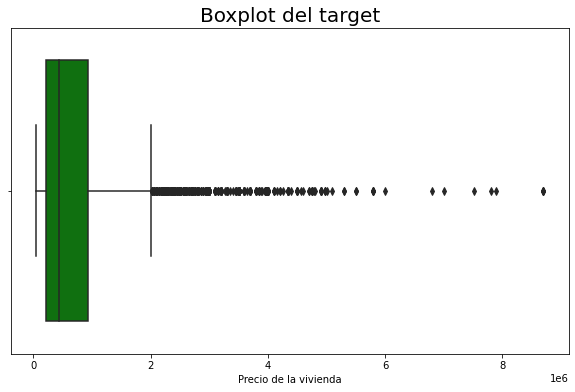

In [75]:
fig_boxplot, ax_boxplot = plt.subplots(figsize=(10,6))
sns.boxplot(x = idealista_madrid_df['price'], color = 'green', ax=ax_boxplot)
ax_boxplot.set_title('Boxplot del target', fontsize=20)  
ax_boxplot.set_xlabel('Precio de la vivienda');

In [27]:
data = idealista_madrid_df['price']

q25 = np.percentile(data,25)
q75 = np.percentile(data,75)
iqr = q75 - q25
cutoff = iqr*1.5
lower = q25 - cutoff
upper = q75 + cutoff

print("q25, q75, iqr:", q25, q75, iqr)
print("q25 - 1.5*iqr:", lower)
print("q75 + 1.5*iqr:", upper)

q25, q75, iqr: 213575.0 931075.0 717500.0
q25 - 1.5*iqr: -862675.0
q75 + 1.5*iqr: 2007325.0


In [29]:
print("Análisis del target (price)")
print("===========================")
print(f"Rango Intercuartílico: {'{:,}'.format(int(q25)).replace(',','.')} - {'{:,}'.format(int(q75)).replace(',','.')}")
nroViviendasMenosQ25 = idealista_madrid_df.loc[(idealista_madrid_df['price'] < q25),["price"]].count().values[0]
print(f"{nroViviendasMenosQ25} viviendas por debajo del percentil 25 de un total de {idealista_madrid_df.shape[0]} viviendas en el Dataset")
nroViviendasMasQ75 = idealista_madrid_df.loc[(idealista_madrid_df['price'] > q75),["price"]].count().values[0]
print(f"{nroViviendasMasQ75} viviendas por encima del percentil 75 de un total de {idealista_madrid_df.shape[0]} viviendas en el Dataset")
nroViviendasIQR = idealista_madrid_df.loc[(idealista_madrid_df['price'] > q25) & (idealista_madrid_df['price'] < q75),["price"]].count().values[0]
print(f"{nroViviendasIQR} viviendas dentro del Rango Intercuartílico de un total de {idealista_madrid_df.shape[0]} viviendas en el Dataset")
nroViviendasUpper = idealista_madrid_df.loc[idealista_madrid_df['price'] > upper,["price"]].count().values[0]
print(f"{nroViviendasUpper} viviendas por encima del percentil 75  + 1.5*IQR de un total de {idealista_madrid_df.shape[0]} viviendas en el Dataset")

Análisis del target (price)
Rango Intercuartil: 213.575 - 931.075
2101 viviendas por debajo del percentil 25 de un total de 8404 viviendas en el Dataset
2101 viviendas por encima del percentil 75 de un total de 8404 viviendas en el Dataset
4202 viviendas dentro del Rango Intercuartil de un total de 8404 viviendas en el Dataset
632 viviendas por encima del percentil 75  + 1.5*IQR de un total de 8404 viviendas en el Dataset


Text(0.5, 0, 'Precio de la vivienda')

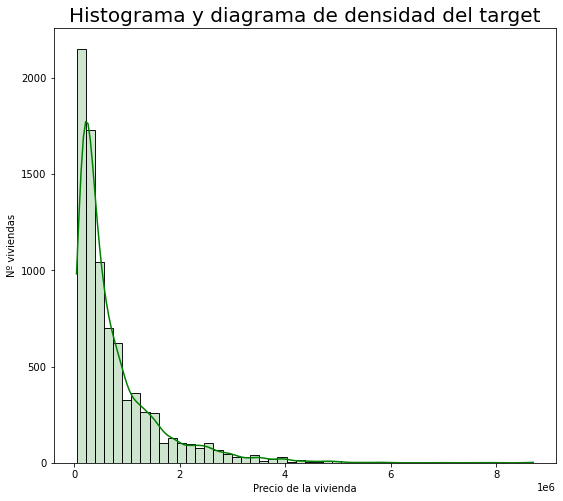

In [68]:
fig_dist, ax_dist = plt.subplots(figsize=(9,8))
sns.histplot(idealista_madrid_df["price"], bins = 50, kde=True, color = 'green', alpha=0.2, ax=ax_dist)
ax_dist.set_title('Histograma y diagrama de densidad del target', fontsize=20)  
ax_dist.set_ylabel('Nº viviendas')
ax_dist.set_xlabel('Precio de la vivienda')

[Ir a inicio](#inicio)

<a id="eliminar_features"></a>
### Eliminación de features

[Descripción de las variables](#variables)

In [113]:
idealista_fe = idealistatools.IdealistaFeatureEngineering(debug = True)

In [114]:
idealista_madrid_clean_df = pd.read_csv(os.path.join(DATA_PATH, 'idealista_madrid_clean.csv'))

In [4]:
idealista_madrid_clean_df.sample(n = 10)

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,topNewDevelopment,newDevelopmentFinished,subTypology,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit,codbarrio,barrio,distrito
4984,92764695,https://img3.idealista.com/blur/WEB_LISTING/0/...,1802/91,10,3.0,79000,flat,sale,68.0,True,...,False,0.0,NaN,False,False,172.0,17.0,17-2,San Cristobal,Villaverde
1432,93482394,https://img3.idealista.com/blur/WEB_LISTING/0/...,341338,62,0.0,1500000,chalet,sale,623.0,False,...,False,0.0,NaN,True,True,93.0,9.0,9-3,Ciudad Universitaria,Moncloa - Aravaca
5123,94283757,https://img3.idealista.com/blur/WEB_LISTING/0/...,14155,23,2.0,980000,penthouse,sale,210.0,True,...,False,0.0,penthouse,False,False,97.0,9.0,9-7,Aravaca,Moncloa - Aravaca
5506,93283153,https://img3.idealista.com/blur/WEB_LISTING/0/...,105588/EV,27,7.0,1140000,flat,sale,206.0,True,...,False,0.0,NaN,True,True,56.0,5.0,5-6,Castilla,Chamartín
5494,94263043,https://img3.idealista.com/blur/WEB_LISTING/0/...,ch-424595,46,3.0,850000,flat,sale,262.0,True,...,False,0.0,NaN,True,True,63.0,6.0,6-3,Castillejos,Tetuán
5055,91670409,https://img3.idealista.com/blur/WEB_LISTING/0/...,e639,26,4.0,645000,flat,sale,102.0,True,...,False,0.0,NaN,True,False,33.0,3.0,3-3,Estrella,Retiro
6321,93745685,https://img3.idealista.com/blur/WEB_LISTING/0/...,V1021,24,1.0,178000,flat,sale,65.0,True,...,False,0.0,NaN,False,False,65.0,6.0,6-5,Valdeacederas,Tetuán
2988,93945847,https://img3.idealista.com/blur/WEB_LISTING/0/...,RP02202183891,26,1.0,139900,flat,sale,93.0,True,...,False,0.0,NaN,False,False,136.0,13.0,13-6,Numancia,Puente de Vallecas
1420,93878256,https://img3.idealista.com/blur/WEB_LISTING/0/...,40.3,26,1.0,1150000,flat,sale,182.0,True,...,False,0.0,NaN,False,False,14.0,1.0,1-4,Justicia,Centro
124,93595604,https://img3.idealista.com/blur/WEB_LISTING/0/...,SAN LORENZO,26,4.0,178000,studio,sale,35.0,False,...,False,0.0,studio,False,False,14.0,1.0,1-4,Justicia,Centro


In [39]:
idealista_madrid_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8404 entries, 0 to 8403
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   propertyCode                   8404 non-null   int64  
 1   thumbnail                      8392 non-null   object 
 2   externalReference              7435 non-null   object 
 3   numPhotos                      8404 non-null   int64  
 4   floor                          8404 non-null   float64
 5   price                          8404 non-null   int64  
 6   propertyType                   8404 non-null   object 
 7   operation                      8404 non-null   object 
 8   size                           8404 non-null   float64
 9   exterior                       8404 non-null   bool   
 10  rooms                          8404 non-null   int64  
 11  bathrooms                      8404 non-null   int64  
 12  address                        8404 non-null   o

[Descripción de las variables](#variables)   

Razones por las que se eliminan features antes de hacer una selección de mejores features:
- **propertyCode**, **externalReference**: son identificadores
- **operation**: todas las muestras con de operación de venta
- **address**: descartamos esta variable en favor del barrio y el distrito
- **province**, **municipality**, **country**:  todas las muestras pertenecen a la cuidad de Madrid, de la provincia Madrid de España
- **district**, **neighborhood**: usaremos en código de barrio (codbar)	y de distrito (coddistrit) obtenidos del *Join Espacial*. Por tanto, también podemos prescindir del nombre del barrio (**barrio**), del nombre del distrito (**distrito**) y otra forma de expresar el código de barrio como string (**codbarrio**)
- Las variables relacionadas con características del anuncio de la web de Idealista no aportan nada a un modelo de Machine Learning: **thumbnail**, **numPhotos**, **showAddress**, **url**, **hasVideo**, **suggestedTexts**, **hasPlan**, **has3DTour**, **has360**, **hasStaging**

- **subTypology**: debido al alto % de nans en esta variable, se decide eliminarla y trabajar con el tipo de propiedad de la variable *propertyType* 

In [14]:
print("***** value_counts propertyType:")
display(idealista_madrid_clean_df['propertyType'].value_counts())
nan_df = idealista_fe.nan_analysis(idealista_madrid_clean_df, display_analysis = False)
print(f"\n***** value_counts subTypology con un {nan_df.loc['subTypology',:]['PorcentajeNulos']:,.2f}% de nans:")
display(idealista_madrid_clean_df['subTypology'].value_counts())

***** value_counts propertyType:


flat         6898
chalet        679
penthouse     380
duplex        282
studio        165
Name: propertyType, dtype: int64

Valores nulos en cada columna:

***** value_counts subTypology con un 82.87% de nans:


penthouse            380
independantHouse     300
duplex               282
studio               165
terracedHouse        162
semidetachedHouse    151
Name: subTypology, dtype: int64

In [115]:
variables_a_eliminar = [
    'propertyCode',
    'externalReference',
    'operation',
    'address',
    'province',
    'municipality',
    'country',
    'district',
    'neighborhood',
    'barrio',
    'distrito',
    'codbarrio',
    'thumbnail',
    'numPhotos',
    'showAddress',
    'url',
    'hasVideo',
    'suggestedTexts',
    'hasPlan',
    'has3DTour',
    'has360',
    'hasStaging',
    'subTypology'
]

idealista_madrid_clean_df2 = idealista_madrid_clean_df.drop(columns=variables_a_eliminar)

In [116]:
idealista_madrid_clean_df2

,floor,price,propertyType,size,exterior,rooms,bathrooms,latitude,longitude,distance,status,newDevelopment,hasLift,priceByArea,topNewDevelopment,newDevelopmentFinished,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit
0,5.0,690000,flat,130.0,False,3,2,40.419046,-3.671944,3975,good,False,1.0,5308,False,0.0,False,False,34.0,3.0
1,2.0,1220000,flat,190.0,True,4,3,40.436636,-3.693064,1481,renew,False,1.0,6421,False,0.0,True,True,74.0,7.0
2,1.0,610000,flat,100.0,True,2,2,40.507182,-3.642583,9397,good,False,1.0,6100,False,0.0,True,True,166.0,16.0
3,1.0,568000,flat,134.0,True,2,2,40.416503,-3.702516,2688,good,False,1.0,4239,False,0.0,False,False,16.0,1.0
4,1.0,800000,flat,139.0,True,3,2,40.422329,-3.707933,1972,good,False,0.0,5755,False,0.0,False,False,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8399,0.0,290000,flat,48.0,True,1,1,40.461255,-3.658644,4946,good,False,1.0,6042,False,0.0,True,True,163.0,16.0
8400,1.0,850000,flat,160.0,True,3,2,40.415587,-3.698285,2889,good,False,1.0,5313,False,0.0,False,False,13.0,1.0
8401,2.0,1250000,flat,220.0,True,8,2,40.421301,-3.705668,2111,renew,False,0.0,5682,False,0.0,False,False,15.0,1.0
8402,4.0,1950000,flat,289.0,True,4,5,40.425214,-3.679031,3093,good,False,1.0,6747,False,0.0,False,False,42.0,4.0


In [117]:
idealista_madrid_clean_df2.to_csv(os.path.join(DATA_PATH, 'idealista_madrid_clean2.csv'), index=False)

<a id="regla_nro-variables"></a>
#### Regla del número de variables

Según la regla de $\text{Nº de variables} = 5 \times \log(N)$ debemos de trabajar con este número de variables para evitar overfitting:

In [24]:
5 * np.log10(idealista_madrid_clean_df2.shape[0])

19.622430218669574

[Ir a inicio](#inicio)

<a id="encoding"></a>
### Endoding de features

In [136]:
idealista_fe = idealistatools.IdealistaFeatureEngineering(debug = True)

In [119]:
idealista_madrid_clean_df2 = pd.read_csv(os.path.join(DATA_PATH, 'idealista_madrid_clean2.csv'))

In [18]:
idealista_madrid_clean_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8404 entries, 0 to 8403
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   floor                          8404 non-null   float64
 1   price                          8404 non-null   int64  
 2   propertyType                   8404 non-null   object 
 3   size                           8404 non-null   float64
 4   exterior                       8404 non-null   bool   
 5   rooms                          8404 non-null   int64  
 6   bathrooms                      8404 non-null   int64  
 7   distance                       8404 non-null   int64  
 8   status                         8404 non-null   object 
 9   newDevelopment                 8404 non-null   bool   
 10  hasLift                        8404 non-null   float64
 11  priceByArea                    8404 non-null   int64  
 12  topNewDevelopment              8404 non-null   b

La variable **price** es el target.

Analicemos el resto de variables:
- A las variables booleanas les asignamos 1 (True) y 0 (False)
- Las variables **hasLift** y **newDevelopmentFinished** que son binarias las convertimos a int32
- Variables categóricas:
  - **propertyType**
  - **status**
  - **codbar**
  - **coddistrit**

In [120]:
idealista_madrid_clean_df2['hasLift'] = idealista_madrid_clean_df2['hasLift'].astype('int32')
idealista_madrid_clean_df2['newDevelopmentFinished'] = idealista_madrid_clean_df2['newDevelopmentFinished'].astype('int32')

In [121]:
idealista_fe.feateures_bool_2_number(idealista_madrid_clean_df2)

In [122]:
idealista_madrid_clean_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8404 entries, 0 to 8403
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   floor                          8404 non-null   float64
 1   price                          8404 non-null   int64  
 2   propertyType                   8404 non-null   object 
 3   size                           8404 non-null   float64
 4   exterior                       8404 non-null   int32  
 5   rooms                          8404 non-null   int64  
 6   bathrooms                      8404 non-null   int64  
 7   latitude                       8404 non-null   float64
 8   longitude                      8404 non-null   float64
 9   distance                       8404 non-null   int64  
 10  status                         8404 non-null   object 
 11  newDevelopment                 8404 non-null   int32  
 12  hasLift                        8404 non-null   i

**propertyType**

In [12]:
idealista_madrid_clean_df2['propertyType'].unique()

array(['flat', 'chalet', 'penthouse', 'duplex', 'studio'], dtype=object)

In [123]:
idealista_madrid_clean_df2 = pd.get_dummies(idealista_madrid_clean_df2, columns=['propertyType'])

**status**

In [16]:
idealista_madrid_clean_df2['status'].unique()

array(['good', 'renew', 'newdevelopment'], dtype=object)

In [124]:
idealista_madrid_clean_df2 = pd.get_dummies(idealista_madrid_clean_df2, columns=['status'])

**codbar**

In [26]:
idealista_madrid_clean_df2['codbar'].nunique()

128

Muchos barrios, por tanto vamos a codificar esta variable con hasher. Antes hay que convertir esta variable a String

In [125]:
idealista_madrid_clean_df2['codbar'] = idealista_madrid_clean_df2['codbar'].astype('str')

In [126]:
hasher_df = idealista_fe.create_featurehasher(idealista_madrid_clean_df2['codbar'], 5, 'codbar')
hasher_df

,codbar_1,codbar_2,codbar_3,codbar_4,codbar_5
0,1.0,0.0,-1.0,-1.0,-1.0
1,0.0,0.0,-1.0,0.0,-1.0
2,2.0,0.0,-1.0,-1.0,-1.0
3,1.0,0.0,-1.0,-1.0,-1.0
4,1.0,0.0,-1.0,-1.0,-1.0
...,...,...,...,...,...
8399,2.0,0.0,-1.0,-1.0,-1.0
8400,1.0,0.0,-1.0,-1.0,-1.0
8401,1.0,0.0,-1.0,-1.0,-1.0
8402,0.0,1.0,-1.0,-1.0,-1.0


In [127]:
idealista_madrid_clean_df2 = pd.concat([idealista_madrid_clean_df2, hasher_df], axis = 1)

**coddistrit**

In [12]:
idealista_madrid_clean_df2['coddistrit'].nunique()

21

Muchos barrios, por tanto vamos a codificar esta variable con hasher. Antes hay que convertir esta variable a String

In [128]:
idealista_madrid_clean_df2['coddistrit'] = idealista_madrid_clean_df2['coddistrit'].astype('str')

In [129]:
hasher_df = idealista_fe.create_featurehasher(idealista_madrid_clean_df2['coddistrit'], 3, 'coddistrit')
hasher_df

,coddistrit_1,coddistrit_2,coddistrit_3
0,1.0,-1.0,-1.0
1,0.0,-1.0,0.0
2,0.0,-2.0,0.0
3,0.0,-2.0,-1.0
4,0.0,-2.0,-1.0
...,...,...,...
8399,0.0,-2.0,0.0
8400,0.0,-2.0,-1.0
8401,0.0,-2.0,-1.0
8402,0.0,-1.0,-2.0


In [130]:
idealista_madrid_clean_df2 = pd.concat([idealista_madrid_clean_df2, hasher_df], axis = 1)

Tras codificar las variables categóricas **codbar** y **coddistrit** las eliminamos.

In [131]:
idealista_madrid_clean_df2 = idealista_madrid_clean_df2.drop(columns=['codbar', 'coddistrit'])

In [132]:
idealista_madrid_clean_df2.sample(n = 10)

,floor,price,size,exterior,rooms,bathrooms,latitude,longitude,distance,newDevelopment,...,status_newdevelopment,status_renew,codbar_1,codbar_2,codbar_3,codbar_4,codbar_5,coddistrit_1,coddistrit_2,coddistrit_3
4561,1.0,685000,134.0,1,5,2,40.415140,-3.679780,3766,0,...,0,1,2.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0
2377,0.0,1330000,480.0,0,6,5,40.505449,-3.689550,7479,0,...,0,0,1.0,0.0,0.0,-2.0,-1.0,-1.0,-1.0,-1.0
7191,3.0,125000,40.0,0,1,1,40.383093,-3.714374,6338,1,...,1,0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-2.0,-1.0
4155,1.0,290000,75.0,0,3,2,40.399632,-3.694681,4672,0,...,0,0,1.0,1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0
8388,1.0,375000,134.0,1,4,2,40.400194,-3.672057,5468,0,...,0,1,1.0,1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0
4906,2.0,199000,133.0,0,4,2,40.379313,-3.706945,6752,0,...,0,0,0.0,1.0,-1.0,0.0,-1.0,1.0,-2.0,-1.0
2498,5.0,3950000,428.0,1,6,6,40.429497,-3.684359,2464,0,...,0,0,1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-2.0
2347,0.0,1090000,386.0,0,5,5,40.477797,-3.739653,4894,0,...,0,0,0.0,1.0,0.0,-2.0,-1.0,-1.0,-1.0,-1.0
5690,3.0,470000,107.0,1,3,2,40.497581,-3.656446,7843,0,...,0,0,2.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0
277,4.0,2150000,320.0,1,4,3,40.413747,-3.690391,3357,0,...,0,0,2.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0


In [137]:
idealista_madrid_clean_df2.to_csv(os.path.join(DATA_PATH, 'idealista_madrid_model1.csv'), index=False)

In [135]:
idealista_madrid_clean_df = pd.read_csv(os.path.join(DATA_PATH, 'idealista_madrid_clean.csv'))
idealista_madrid_clean_df

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,topNewDevelopment,newDevelopmentFinished,subTypology,hasParkingSpace,isParkingSpaceIncludedInPrice,codbar,coddistrit,codbarrio,barrio,distrito
0,93868909,https://img3.idealista.com/blur/WEB_LISTING/0/...,lm161734,32,5.0,690000,flat,sale,130.0,False,...,False,0.0,NaN,False,False,34.0,3.0,3-4,Ibiza,Retiro
1,93242574,https://img3.idealista.com/blur/WEB_LISTING/0/...,MV3938I,51,2.0,1220000,flat,sale,190.0,True,...,False,0.0,NaN,True,True,74.0,7.0,7-4,Almagro,Chamberí
2,92931772,https://img3.idealista.com/blur/WEB_LISTING/0/...,V6573I,48,1.0,610000,flat,sale,100.0,True,...,False,0.0,NaN,True,True,166.0,16.0,16-6,Valdefuentes,Hortaleza
3,93759548,https://img3.idealista.com/blur/WEB_LISTING/0/...,GM 160949,48,1.0,568000,flat,sale,134.0,True,...,False,0.0,NaN,False,False,16.0,1.0,1-6,Sol,Centro
4,93591362,https://img3.idealista.com/blur/WEB_LISTING/0/...,AS 159887,34,1.0,800000,flat,sale,139.0,True,...,False,0.0,NaN,False,False,15.0,1.0,1-5,Universidad,Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8399,90254228,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM2007009,16,0.0,290000,flat,sale,48.0,True,...,False,0.0,NaN,True,True,163.0,16.0,16-3,Canillas,Hortaleza
8400,87878805,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1911049,19,1.0,850000,flat,sale,160.0,True,...,False,0.0,NaN,False,False,13.0,1.0,1-3,Cortes,Centro
8401,87375364,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1910036,19,2.0,1250000,flat,sale,220.0,True,...,False,0.0,NaN,False,False,15.0,1.0,1-5,Universidad,Centro
8402,85504146,https://img3.idealista.com/blur/WEB_LISTING/0/...,VM1811046,32,4.0,1950000,flat,sale,289.0,True,...,False,0.0,NaN,False,False,42.0,4.0,4-2,Goya,Salamanca


In [137]:
idealista_madrid_clean_df['codbar'] = idealista_madrid_clean_df['codbar'].astype('str')
hasher_df = idealista_fe.create_featurehasher(idealista_madrid_clean_df['codbar'], 5, 'codbar')
idealista_madrid_clean_df = pd.concat([idealista_madrid_clean_df, hasher_df], axis = 1)

In [138]:
idealista_madrid_clean_df['coddistrit'] = idealista_madrid_clean_df['coddistrit'].astype('str')
hasher_df = idealista_fe.create_featurehasher(idealista_madrid_clean_df['coddistrit'], 3, 'coddistrit')
idealista_madrid_clean_df = pd.concat([idealista_madrid_clean_df, hasher_df], axis = 1)

In [139]:
idealista_madrid_clean_df.head()

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,barrio,distrito,codbar_1,codbar_2,codbar_3,codbar_4,codbar_5,coddistrit_1,coddistrit_2,coddistrit_3
0,93868909,https://img3.idealista.com/blur/WEB_LISTING/0/...,lm161734,32,5.0,690000,flat,sale,130.0,False,...,Ibiza,Retiro,1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
1,93242574,https://img3.idealista.com/blur/WEB_LISTING/0/...,MV3938I,51,2.0,1220000,flat,sale,190.0,True,...,Almagro,Chamberí,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
2,92931772,https://img3.idealista.com/blur/WEB_LISTING/0/...,V6573I,48,1.0,610000,flat,sale,100.0,True,...,Valdefuentes,Hortaleza,2.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0
3,93759548,https://img3.idealista.com/blur/WEB_LISTING/0/...,GM 160949,48,1.0,568000,flat,sale,134.0,True,...,Sol,Centro,1.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
4,93591362,https://img3.idealista.com/blur/WEB_LISTING/0/...,AS 159887,34,1.0,800000,flat,sale,139.0,True,...,Universidad,Centro,1.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0


In [141]:
barrio_dist_df = idealista_madrid_clean_df[["barrio","distrito","codbar_1","codbar_2","codbar_3","codbar_4","codbar_5","coddistrit_1","coddistrit_2","coddistrit_3"]]
barrio_dist_df.drop_duplicates(subset=["barrio","distrito"], inplace=True)
barrio_dist_df

<ipython-input-141-fc2300f53880>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barrio_dist_df.drop_duplicates(subset=["barrio","distrito"], inplace=True)


,barrio,distrito,codbar_1,codbar_2,codbar_3,codbar_4,codbar_5,coddistrit_1,coddistrit_2,coddistrit_3
0,Ibiza,Retiro,1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
1,Almagro,Chamberí,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
2,Valdefuentes,Hortaleza,2.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0
3,Sol,Centro,1.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
4,Universidad,Centro,1.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
1484,Atocha,Arganzuela,0.0,1.0,0.0,0.0,-1.0,1.0,-1.0,-1.0
1902,Ambroz,Vicálvaro,0.0,2.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0
2088,Cuatro Vientos,Latina,1.0,0.0,-1.0,-1.0,-2.0,0.0,-3.0,-1.0
2291,Vinateros,Moratalaz,1.0,0.0,-2.0,-1.0,-1.0,0.0,-2.0,-2.0


In [142]:
# Dataset para codificar barrios y distritos a la hora de predecir el precio nuevas viviendas en venta
barrio_dist_df.to_csv(os.path.join(DATA_PATH, 'barrio_dist_df.csv'), index=False)

[Ir a inicio](#inicio)

<a id="machinelearning"></a>
## Machine Learning

<a id="div_train-test"></a>
### División train-test

In [26]:
idealista_madrid_model_df = pd.read_csv(os.path.join(DATA_PATH, 'idealista_madrid_model1.csv'))

In [12]:
X = idealista_madrid_model_df.drop(columns='price')
y = idealista_madrid_model_df['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [39]:
display(idealista_madrid_model_df.shape)
display(X_train.shape)
display(y_train.shape)
display(X_train)
display(y_train)

(8404, 32)

(6723, 31)

(6723,)

,floor,size,exterior,rooms,bathrooms,latitude,longitude,distance,newDevelopment,hasLift,...,status_newdevelopment,status_renew,codbar_1,codbar_2,codbar_3,codbar_4,codbar_5,coddistrit_1,coddistrit_2,coddistrit_3
323,2.0,26.0,0,1,1,40.458198,-3.707394,2035,0,0,...,0,0,2.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0
2412,3.0,262.0,1,5,4,40.461711,-3.692207,2845,0,1,...,0,0,2.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0
5967,1.0,63.0,1,1,1,40.409648,-3.700738,3464,0,0,...,0,0,0.0,1.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
2464,0.0,60.0,0,0,1,40.406914,-3.710959,3679,0,1,...,0,0,0.0,1.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
2245,0.0,52.0,1,2,1,40.465474,-3.703038,2893,0,0,...,0,0,2.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.0,97.0,1,3,2,40.389266,-3.635011,8492,0,1,...,0,0,1.0,0.0,-2.0,-1.0,-1.0,1.0,-2.0,-1.0
5191,0.0,413.0,0,6,4,40.466469,-3.726610,3261,0,0,...,0,0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0
5390,2.0,103.0,0,4,2,40.417931,-3.672378,4020,0,1,...,0,1,1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
860,0.0,75.0,1,2,2,40.470882,-3.582895,11288,1,1,...,1,0,0.0,1.0,-2.0,-1.0,-1.0,1.0,-2.0,-1.0


323       85000
2412     850000
5967     198000
2464     225000
2245     160000
         ...   
5734     155000
5191    1199000
5390     485000
860      239000
7270     148630
Name: price, Length: 6723, dtype: int64

In [41]:
with open(os.path.join(DATA_PATH, 'X_train.df'), 'wb') as archivo_salida:
    pickle.dump(X_train, archivo_salida)

with open(os.path.join(DATA_PATH, 'y_train.serie'), 'wb') as archivo_salida:
    pickle.dump(y_train, archivo_salida)

with open(os.path.join(DATA_PATH, 'X_test.df'), 'wb') as archivo_salida:
    pickle.dump(X_test, archivo_salida)

with open(os.path.join(DATA_PATH, 'y_test.serie'), 'wb') as archivo_salida:
    pickle.dump(y_test, archivo_salida)

[Modelado](#modelado)

[Ir a inicio](#inicio)

<a id="feature_selection"></a>
### Selección de Features

In [17]:
idealista_ml = idealistatools.IdealistaML(debug = True)

In [18]:
train_df = pd.concat([X_train,y_train],axis=1)

In [16]:
train_df.sample(n = 10)

,floor,size,exterior,rooms,bathrooms,latitude,longitude,distance,newDevelopment,hasLift,...,status_renew,codbar_1,codbar_2,codbar_3,codbar_4,codbar_5,coddistrit_1,coddistrit_2,coddistrit_3,price
3847,2.0,140.0,1,4,2,40.383295,-3.611707,10440,0,1,...,0,0.0,1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,246000
3266,3.0,138.0,1,3,3,40.482157,-3.672663,5652,0,1,...,0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-2.0,-1.0,560000
7709,1.0,81.0,1,1,1,40.447859,-3.686274,2189,0,1,...,0,1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,750000
7931,2.0,300.0,1,5,6,40.458100,-3.792310,7249,0,1,...,0,0.0,1.0,0.0,0.0,-1.0,0.0,-1.0,0.0,1450000
1361,4.0,288.0,1,5,4,40.437479,-3.694405,1349,0,1,...,1,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1830000
2880,1.0,73.0,1,4,1,40.391783,-3.734850,5759,0,0,...,0,1.0,0.0,-2.0,-1.0,-1.0,0.0,-3.0,-1.0,169000
5344,4.0,108.0,1,4,2,40.398640,-3.671356,5643,0,1,...,0,1.0,1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,425000
5729,4.0,130.0,1,3,2,40.420437,-3.675400,3647,0,1,...,0,1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,625000
7700,5.0,250.0,1,4,3,40.426487,-3.683403,2706,0,1,...,1,0.0,0.0,-2.0,-1.0,-1.0,0.0,-1.0,-2.0,1900000
3886,0.0,78.0,1,3,2,40.408035,-3.673590,4704,0,0,...,1,2.0,0.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,310500


<a id="analisis_corr"></a>
### Análisis de correlación

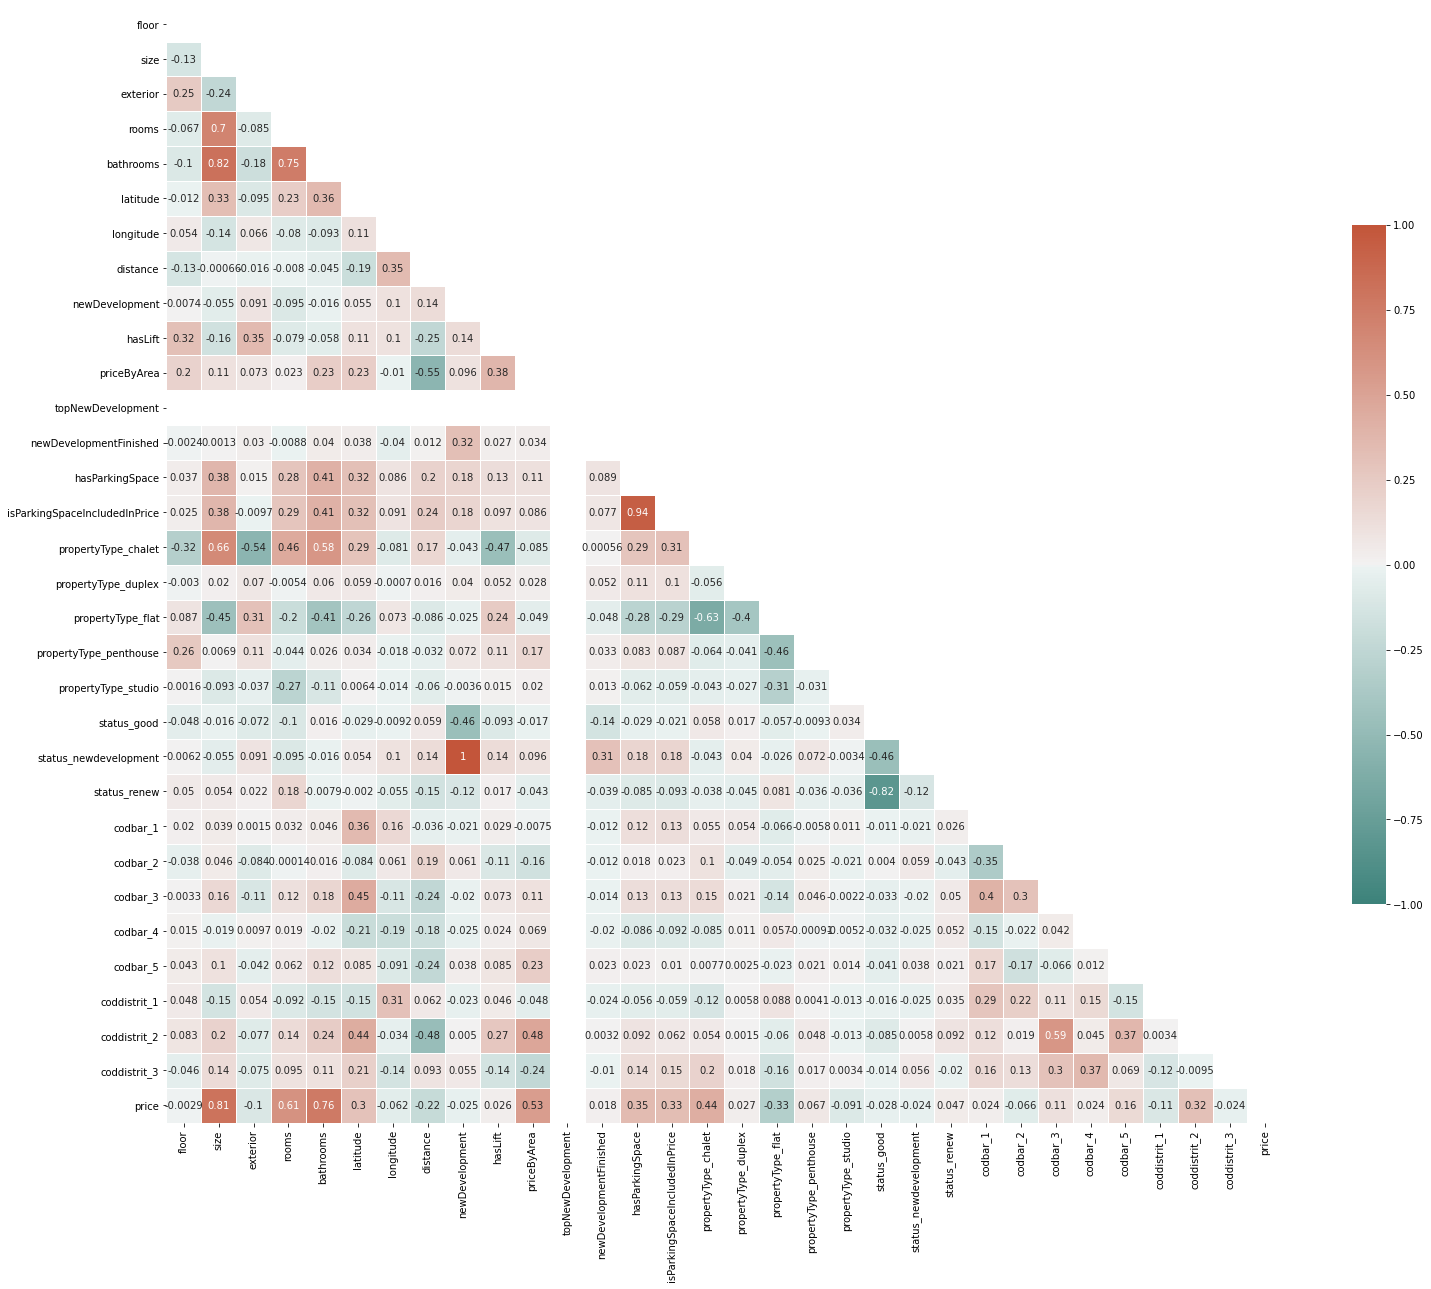

In [19]:
correlation = idealista_ml.correlation_analysis(train_df, show_heatmap = True, figsize=(25,25))

In [20]:
corr_price = np.abs(correlation['price']).sort_values(ascending=False)
corr_price

price                            1.000000
size                             0.805540
bathrooms                        0.758773
rooms                            0.606895
priceByArea                      0.533804
propertyType_chalet              0.435338
hasParkingSpace                  0.346859
isParkingSpaceIncludedInPrice    0.334702
propertyType_flat                0.325236
coddistrit_2                     0.317366
latitude                         0.297665
distance                         0.218048
codbar_5                         0.155979
codbar_3                         0.110749
coddistrit_1                     0.105368
exterior                         0.103171
propertyType_studio              0.091277
propertyType_penthouse           0.067314
codbar_2                         0.066085
longitude                        0.062492
status_renew                     0.046638
status_good                      0.027758
propertyType_duplex              0.027088
hasLift                          0

In [21]:
bad_corr_feat = corr_price[(corr_price < 0.1) | np.isnan(corr_price)].index.values
bad_corr_feat
#corr_price.drop(labels=bad_corr_feat)

array(['propertyType_studio', 'propertyType_penthouse', 'codbar_2',
       'longitude', 'status_renew', 'status_good', 'propertyType_duplex',
       'hasLift', 'newDevelopment', 'status_newdevelopment', 'codbar_1',
       'codbar_4', 'coddistrit_3', 'newDevelopmentFinished', 'floor',
       'topNewDevelopment'], dtype=object)

Conclusiones del análisis de Correlación lineal sobre las variables candidatas a eliminar:
- **status_newdevelopment** y **newDevelopment** están fuertemente correlacionadas   
  Como están poco correlacionadas con el target, las eliminamos.
- **hasParkingSpace** y **isParkingSpaceIncludedInPrice** están fuertemente correlacionadas   
  Eliminamos *isParkingSpaceIncludedInPrice* porque está menos correlacionada con el target que *hasParkingSpace*
- Se pueden eliminar todas las variables con correlación con el target menor a 0.1.

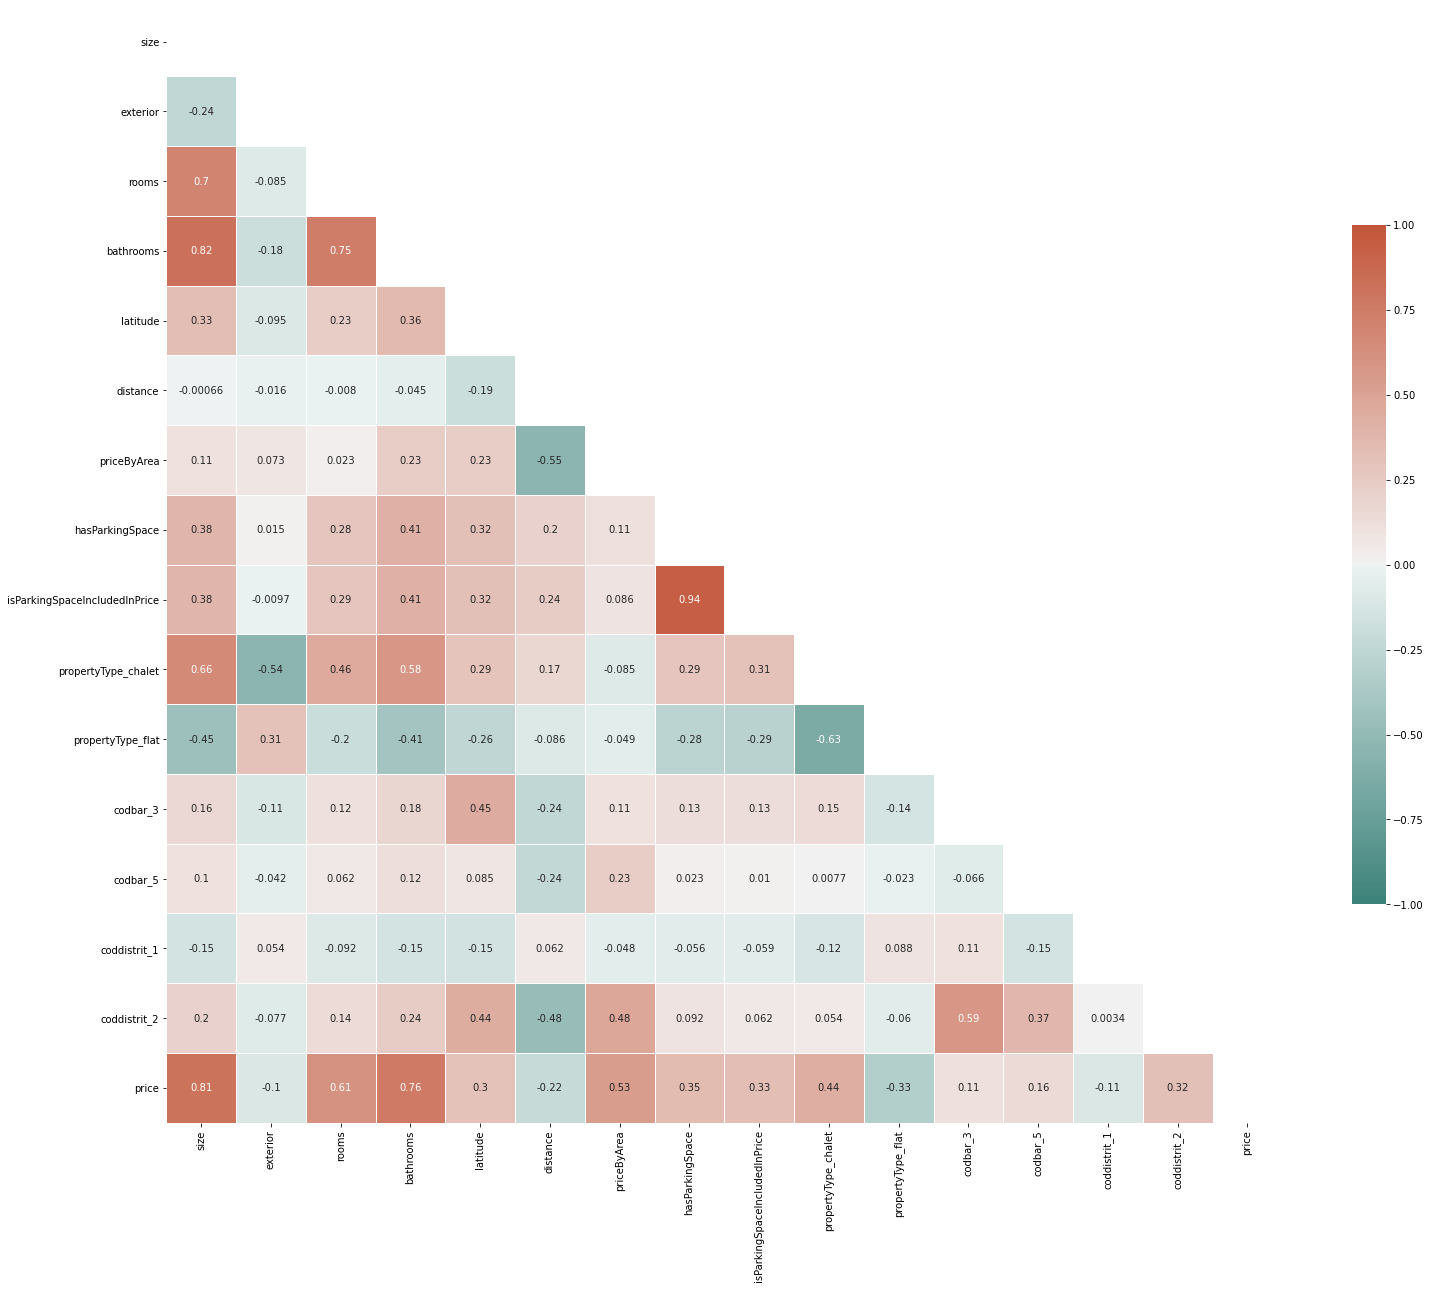

In [22]:
train_df2 = train_df.drop(columns=bad_corr_feat)
idealista_ml.correlation_analysis(train_df2,
                                  show_heatmap = True,
                                  figsize=(25,25));

In [23]:
# Eliminamos el target y isParkingSpaceIncludedInPrice fuertemente correlacionado con hasParkingSpace
columnas_corr_lineal = train_df2.columns.drop(labels=['price', 'isParkingSpaceIncludedInPrice']).values
display(columnas_corr_lineal)
k_best = len(columnas_corr_lineal)
k_best

array(['size', 'exterior', 'rooms', 'bathrooms', 'latitude', 'distance',
       'priceByArea', 'hasParkingSpace', 'propertyType_chalet',
       'propertyType_flat', 'codbar_3', 'codbar_5', 'coddistrit_1',
       'coddistrit_2'], dtype=object)

14

[Ir a inicio](#inicio)

<a id="selectkbest"></a>
### SelectKBest

In [24]:
# k_best es el múmero de columnas resultado del análisis de correlación.
sel = SelectKBest(f_regression, k=k_best)

# de X eliminamos el target y de los pares de variables fuertemente correlacionadas, la menos correlacionada con el target 
X = X_train.drop(columns=['status_newdevelopment', 'isParkingSpaceIncludedInPrice'])
y = y_train

sel.fit(X, y)
select_kbest_df = pd.DataFrame({'column': X.columns.values, 'score': sel.scores_}).sort_values('score', ascending=False)
select_kbest_df

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


,column,score
1,size,12421.434770
4,bathrooms,9120.553317
3,rooms,3918.897421
10,priceByArea,2678.305482
14,propertyType_chalet,1571.610305
13,hasParkingSpace,919.201402
16,propertyType_flat,795.034364
27,coddistrit_2,752.766426
5,latitude,653.405588
7,distance,335.499308


In [25]:
columnas_select_kbest = select_kbest_df.iloc[:k_best,:]['column'].values
display(columnas_select_kbest)
display(len(columnas_select_kbest))

array(['size', 'bathrooms', 'rooms', 'priceByArea', 'propertyType_chalet',
       'hasParkingSpace', 'propertyType_flat', 'coddistrit_2', 'latitude',
       'distance', 'codbar_5', 'codbar_3', 'coddistrit_1', 'exterior'],
      dtype=object)

14

[Ir a inicio](#inicio)

<a id="RandomForestRegressor"></a>
### RandomForestRegressor

In [26]:
rf = RandomForestRegressor(n_estimators = 200)
rf.fit(X, y)

RandomForestRegressor(n_estimators=200)

In [27]:
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X.columns.values), reverse=True)
rf_regressor_df = pd.DataFrame(scores, columns=['Score', 'Feature'])
rf_regressor_df

,Score,Feature
0,0.7847,size
1,0.2088,priceByArea
2,0.0012,longitude
3,0.0011,latitude
4,0.0009,distance
5,0.0007,rooms
6,0.0004,floor
7,0.0004,bathrooms
8,0.0003,exterior
9,0.0002,coddistrit_1


In [28]:
columnas_rf_regressor = rf_regressor_df.iloc[:k_best,:]['Feature'].values
display(columnas_rf_regressor)
display(len(columnas_rf_regressor))

array(['size', 'priceByArea', 'longitude', 'latitude', 'distance',
       'rooms', 'floor', 'bathrooms', 'exterior', 'coddistrit_1',
       'codbar_1', 'status_renew', 'status_good', 'propertyType_flat'],
      dtype=object)

14

[Ir a inicio](#inicio)

<a id="conc_sel_feat"></a>
### Conclusiones Seleccion de Features

In [29]:
columnas_corr_lineal_ord = np.sort(columnas_corr_lineal)
columnas_select_kbest_ord = np.sort(columnas_select_kbest)
columnas_rf_regressor_ord = np.sort(columnas_rf_regressor)

In [30]:
sel_features = pd.DataFrame({
                                "CorrelacionLinea": columnas_corr_lineal,
                                "SelectKBest": columnas_select_kbest,
                                "RandomForestRegressor": columnas_rf_regressor,
                                "CorrelacionLineaOrd": columnas_corr_lineal_ord,
                                "SelectKBestOrd": columnas_select_kbest_ord,
                                "RandomForestRegressorOrd": columnas_rf_regressor_ord
                            })
sel_features

,CorrelacionLinea,SelectKBest,RandomForestRegressor,CorrelacionLineaOrd,SelectKBestOrd,RandomForestRegressorOrd
0,size,size,size,bathrooms,bathrooms,bathrooms
1,exterior,bathrooms,priceByArea,codbar_3,codbar_3,codbar_1
2,rooms,rooms,longitude,codbar_5,codbar_5,coddistrit_1
3,bathrooms,priceByArea,latitude,coddistrit_1,coddistrit_1,distance
4,latitude,propertyType_chalet,distance,coddistrit_2,coddistrit_2,exterior
5,distance,hasParkingSpace,rooms,distance,distance,floor
6,priceByArea,propertyType_flat,floor,exterior,exterior,latitude
7,hasParkingSpace,coddistrit_2,bathrooms,hasParkingSpace,hasParkingSpace,longitude
8,propertyType_chalet,latitude,exterior,latitude,latitude,priceByArea
9,propertyType_flat,distance,coddistrit_1,priceByArea,priceByArea,propertyType_flat


In [31]:
features_aux = np.concatenate((columnas_corr_lineal, columnas_select_kbest, columnas_rf_regressor), axis=0)
sel_features_count_df = pd.DataFrame({'Features': features_aux, "Count": 1})
sel_features_count = sel_features_count_df['Features'].value_counts()
sel_features_count

exterior               3
distance               3
size                   3
rooms                  3
priceByArea            3
propertyType_flat      3
latitude               3
coddistrit_1           3
bathrooms              3
coddistrit_2           2
propertyType_chalet    2
codbar_3               2
codbar_5               2
hasParkingSpace        2
status_renew           1
floor                  1
codbar_1               1
status_good            1
longitude              1
Name: Features, dtype: int64

In [32]:
# Nos quedamos con las features que aparecen en al menos 2 métodos de selección de features
features_selected = sel_features_count[sel_features_count > 1].index.values
display(features_selected)
display(len(features_selected))

array(['exterior', 'distance', 'size', 'rooms', 'priceByArea',
       'propertyType_flat', 'latitude', 'coddistrit_1', 'bathrooms',
       'coddistrit_2', 'propertyType_chalet', 'codbar_3', 'codbar_5',
       'hasParkingSpace'], dtype=object)

14

In [33]:
np.savez(os.path.join(DATA_PATH, 'features_selected.npz'), features_selected=features_selected)

[Regla del número de valriables](#regla_nro-variables)

[Ir a inicio](#inicio)

<a id="modelado"></a>
### Modelado

In [4]:
data = np.load(os.path.join(DATA_PATH, 'features_selected.npz'), allow_pickle=True)
features_selected = data['features_selected']
features_selected

with open(os.path.join(DATA_PATH, 'X_train.df'), 'rb') as archivo_entrada:
    X_train = pickle.load(archivo_entrada)

with open(os.path.join(DATA_PATH, 'y_train.serie'), 'rb') as archivo_entrada:
    y_train = pickle.load(archivo_entrada)

with open(os.path.join(DATA_PATH, 'X_test.df'), 'rb') as archivo_entrada:
    X_test = pickle.load(archivo_entrada)

with open(os.path.join(DATA_PATH, 'y_test.serie'), 'rb') as archivo_entrada:
    y_test = pickle.load(archivo_entrada)

In [6]:
X_train2 = X_train[features_selected]
display(X_train2)
X_test2 = X_test[features_selected]
display(X_test2)

,exterior,distance,size,rooms,priceByArea,propertyType_flat,latitude,coddistrit_1,bathrooms,coddistrit_2,propertyType_chalet,codbar_3,codbar_5,hasParkingSpace
323,0,2035,26.0,1,3269,1,40.458198,0.0,1,-1.0,0,0.0,-1.0,0
2412,1,2845,262.0,5,3244,1,40.461711,0.0,4,-1.0,0,0.0,-1.0,1
5967,1,3464,63.0,1,3143,1,40.409648,0.0,1,-2.0,0,-1.0,-1.0,0
2464,0,3679,60.0,0,3750,0,40.406914,0.0,1,-2.0,0,-1.0,-1.0,0
2245,1,2893,52.0,2,3077,1,40.465474,0.0,1,-1.0,0,0.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1,8492,97.0,3,1598,1,40.389266,1.0,2,-2.0,0,-2.0,-1.0,0
5191,0,3261,413.0,6,2903,0,40.466469,0.0,4,-1.0,1,0.0,-1.0,1
5390,0,4020,103.0,4,4709,1,40.417931,1.0,2,-1.0,0,-1.0,-1.0,0
860,1,11288,75.0,2,3187,1,40.470882,1.0,2,-2.0,0,-2.0,-1.0,1


,exterior,distance,size,rooms,priceByArea,propertyType_flat,latitude,coddistrit_1,bathrooms,coddistrit_2,propertyType_chalet,codbar_3,codbar_5,hasParkingSpace
518,0,3694,51.0,2,2784,1,40.473224,-1.0,1,-1.0,0,-1.0,-1.0,0
6681,1,2499,404.0,5,10767,1,40.428922,0.0,6,-1.0,0,-2.0,-1.0,0
233,1,4684,39.0,0,4744,0,40.441719,1.0,1,-2.0,0,-1.0,-1.0,0
6928,1,2894,223.0,5,4036,1,40.436119,0.0,2,-1.0,0,-1.0,-1.0,1
5880,1,4899,93.0,2,6430,1,40.453535,1.0,2,-2.0,0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7203,1,10848,65.0,3,1669,1,40.343547,0.0,1,-2.0,0,-1.0,-1.0,0
7132,0,3603,37.0,1,2973,1,40.407978,0.0,1,-2.0,0,-1.0,-1.0,0
1515,1,3097,231.0,3,7143,0,40.427743,0.0,3,-1.0,0,-1.0,-1.0,0
216,0,8865,992.0,7,1764,0,40.469962,0.0,7,-1.0,1,0.0,-1.0,1


In [183]:
# Primero estandarizamos las variables a usar en los modelos

scaler = MinMaxScaler()
scaler.fit(X_train2)
X_train_scal = scaler.transform(X_train2)
X_test_scal = scaler.transform(X_test2)

In [184]:
X_train_scal

array([[0.        , 0.12870005, 0.00752508, ..., 1.        , 1.        ,
        0.        ],
       [1.        , 0.18116458, 0.10618729, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.22125785, 0.02299331, ..., 0.66666667, 1.        ,
        0.        ],
       ...,
       [0.        , 0.25727055, 0.03971572, ..., 0.66666667, 1.        ,
        0.        ],
       [1.        , 0.72802643, 0.02801003, ..., 0.33333333, 1.        ,
        1.        ],
       [1.        , 0.67582097, 0.0388796 , ..., 0.33333333, 1.        ,
        0.        ]])

In [185]:
with open(os.path.join(MODELS_PATH, 'minmaxscaler.scaler'), 'wb') as archivo_salida:
    pickle.dump(scaler, archivo_salida)

[Ir a inicio](#inicio)

<a id="select_model"></a>
#### Decidir qué modelo Machine Learning usar

El target a predecir es el precio de la vivienda, por lo tanto tenemos que crear un modelo de Machine Learning de regresión.   
Con ayuda de **GridSearchCV** vamos a probar el desempeño de varios modelos de regresión: LinearRegression, DecisionTreeRegressor, LinearSVR y SVR.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

lin_reg = LinearRegression()

dt_reg = DecisionTreeRegressor()
dt_reg_param = {
    "max_depth": np.arange(2,10)
}

lin_svr = LinearSVR()
lin_svr_param = {
    "epsilon": np.arange(1.5, 5, 0.5),
    "max_iter": [1000, 1500, 200]
}

svr = SVR()
svr_param = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [2,3],
    "C": [0.01, 0.1, 1.0, 10, 100],
    "epsilon": np.arange(0.1,0.5,0.1),
    "gamma": ['scale', 'auto']
}

gs_lin_reg = GridSearchCV(lin_reg,
                          {},
                          cv = 10, 
                          scoring='r2',
                          n_jobs = -1,
                          verbose = 1)

gs_dt_reg = GridSearchCV(dt_reg,
                         dt_reg_param,
                         cv = 10, 
                         scoring='r2',
                         n_jobs = -1,
                         verbose = 1)

gs_lin_svr = GridSearchCV(lin_svr,
                         lin_svr_param,
                         cv = 10, 
                         scoring='r2',
                         n_jobs = -1,
                         verbose = 1)

gs_svr = GridSearchCV(svr,
                      svr_param,
                      cv = 10, 
                      scoring='r2',
                      n_jobs = -1,
                      verbose = 1)

grids = {
    "gs_lin_reg": gs_lin_reg,
    "gs_dt_reg": gs_dt_reg,
    "gs_lin_svr": gs_lin_svr,
    "gs_svr": gs_svr
}

In [10]:
for nombre, grid_search in grids.items():
    grid_search.fit(X_train_scal, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 21 candidates, totalling 210 fits
Fitting 10 folds for each of 320 candidates, totalling 3200 fits


In [11]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns =["Grid", "Best score"])
best_grids.sort_values(by = "Best score", ascending=False,  inplace=True, ignore_index=True)
display(best_grids)
best_gs = grids[best_grids.iat[0,0]]
display(best_gs)

,Grid,Best score
0,gs_dt_reg,0.977461
1,gs_lin_reg,0.870808
2,gs_svr,0.183336
3,gs_lin_svr,-0.738661


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='r2', verbose=1)

In [12]:
print("Best estimator:", best_gs.best_estimator_)
print("Best params:", best_gs.best_params_)
print("Best score:", best_gs.best_score_)

Best estimator: DecisionTreeRegressor(max_depth=9)
Best params: {'max_depth': 9}
Best score: 0.9774611505867498


In [13]:
with open(os.path.join(MODELS_PATH, 'best_GridSearchCV.gs'), 'wb') as archivo_salida:
    pickle.dump(best_gs, archivo_salida)

[Ir a inicio](#inicio)

<a id="evaluate_model"></a>
#### Evaluar el modelo Machine Learning elegido con test y medir su desempeño

A continuación evaluamos el modelo de Machine Learning elegido con datos de test y medimos su desempeño para descartar que hayamos incurrido en overfitting.

In [14]:
with open(os.path.join(MODELS_PATH, 'best_GridSearchCV.gs'), 'rb') as archivo_entrada:
    best_gs = pickle.load(archivo_entrada)

In [15]:
y_pred = best_gs.best_estimator_.predict(X_test_scal)

In [17]:
test_df = pd.DataFrame({"y_test": y_test, "y_pred": y_pred, "residuo": (y_test - y_pred).abs().round(2)})
test_df

,y_test,y_pred,residuo
518,142000,1.578955e+05,15895.51
6681,4350000,4.293125e+06,56875.00
233,185000,1.810581e+05,3941.94
6928,900000,9.102500e+05,10250.00
5880,598000,5.833412e+05,14658.82
...,...,...,...
7203,108500,9.123118e+04,17268.82
7132,110000,1.277585e+05,17758.46
1515,1650000,1.560856e+06,89143.75
216,1750000,1.640000e+06,110000.00


In [26]:
test_df['residuo'].mean()

37704.20000594884

<AxesSubplot:>

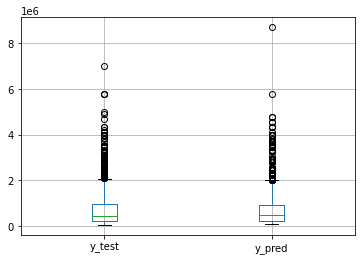

In [16]:
test_df[['y_test','y_pred']].boxplot()

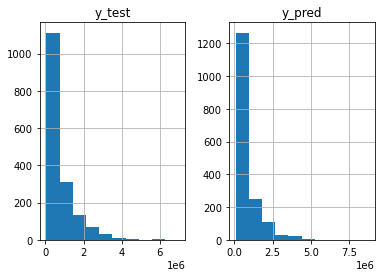

In [17]:
test_df[['y_test','y_pred']].hist();

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 46.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 54.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='y_pred'>

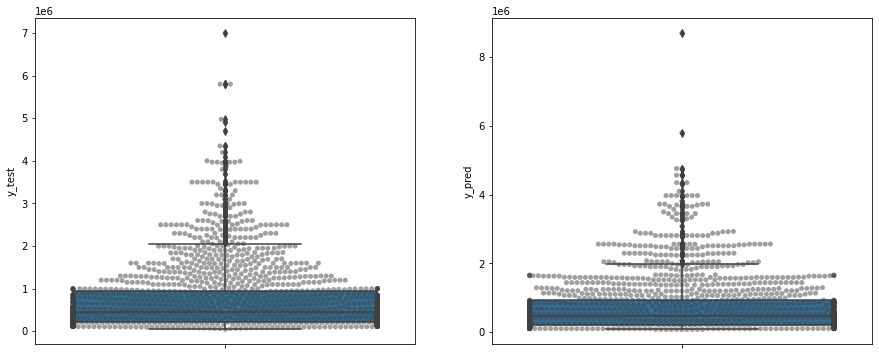

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.boxplot(y=test_df['y_test'], ax=ax[0])
sns.swarmplot(y=test_df['y_test'], color=".25", alpha=0.5, ax=ax[0])
sns.boxplot(y=test_df['y_pred'], ax=ax[1])
sns.swarmplot(y=test_df['y_pred'], color=".25", alpha=0.5, ax=ax[1])

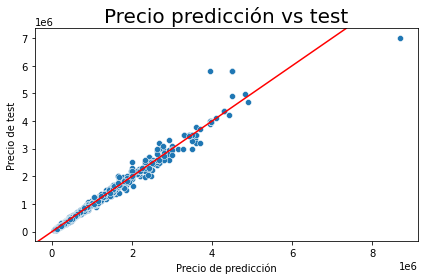

In [24]:
fig, ax = plt.subplots()
sns.scatterplot(x = y_pred, y = y_test, ax=ax)
ax.set_title('Precio predicción vs test', fontsize=20)  
ax.set_xlabel('Precio de predicción')
ax.set_ylabel('Precio de test')
plt.axline([0,0],[1,1],color='red')
plt.tight_layout()
fig.savefig(os.path.join(IMAGES_PATH, 'fig_ml_pred_vs_test.png'))

In [25]:
# Medir desempeño del modelo
print("Desempeño del modelo con el conjunto de datos de training")
print("---------------------------------------------------------")
print("RMSE:", mean_squared_error(y_train,best_gs.best_estimator_.predict(X_train_scal), squared=False))
print("R2 score:", best_gs.best_estimator_.score(X_train_scal, y_train))
print()
print("Desempeño del modelo con el conjunto de datos de test")
print("-----------------------------------------------------")
print("RMSE:",mean_squared_error(y_test, y_pred, squared=False))
print("R2 score:", best_gs.best_estimator_.score(X_test_scal, y_test))

Desempeño del modelo con el conjunto de datos de training
---------------------------------------------------------
RMSE: 36870.55025981314
R2 score: 0.9980227885649285

Desempeño del modelo con el conjunto de datos de test
-----------------------------------------------------
RMSE: 100820.11042630023
R2 score: 0.9848803084907667


El desempeño del modelo de Machine Learning con datos de train y datos de test confirman que **no hay overfitting** con el data set utilizado en este proyecto. Habrá que ver el funcionamiento del modelos a la hora de predecir el valor de nuevas viviendas publicadas en el portal de Idealista.

[Ir a inicio](#inicio)

<a id="predict_new_ml"></a>
#### Predecir nuevas viviendas con el modelo de Machine Learning

In [69]:
# TODO: Buscar pisos en venta en la web y crear un vectos con estas variables para predecir y conparar el precio resultante
print(features_selected)

['bathrooms' 'propertyType_flat' 'rooms' 'latitude' 'size' 'distance'
 'hasParkingSpace' 'priceByArea' 'propertyType_chalet' 'coddistrit_2'
 'codbar_5' 'coddistrit_1' 'exterior' 'codbar_3']


In [13]:
with open(os.path.join(MODELS_PATH, 'best_GridSearchCV.gs'), 'rb') as archivo_entrada:
    best_gs = pickle.load(archivo_entrada)

##### Obtener datos de un anuncio de Idealista

Ejemplo de un anuncio de Idealista: https://www.idealista.com/inmueble/94830602/

In [8]:
barrio_dist_df = pd.read_csv(os.path.join(DATA_PATH, 'barrio_dist_df.csv'))
barrio_dist_df

,barrio,distrito,codbar_1,codbar_2,codbar_3,codbar_4,codbar_5,coddistrit_1,coddistrit_2,coddistrit_3
0,Ibiza,Retiro,1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
1,Almagro,Chamberí,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
2,Valdefuentes,Hortaleza,2.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0
3,Sol,Centro,1.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
4,Universidad,Centro,1.0,0.0,-1.0,-1.0,-1.0,0.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
123,Atocha,Arganzuela,0.0,1.0,0.0,0.0,-1.0,1.0,-1.0,-1.0
124,Ambroz,Vicálvaro,0.0,2.0,-1.0,-1.0,-1.0,0.0,-2.0,0.0
125,Cuatro Vientos,Latina,1.0,0.0,-1.0,-1.0,-2.0,0.0,-3.0,-1.0
126,Vinateros,Moratalaz,1.0,0.0,-2.0,-1.0,-1.0,0.0,-2.0,-2.0


In [186]:
with open(os.path.join(MODELS_PATH, 'minmaxscaler.scaler'), 'rb') as archivo_entrada:
    scaler = pickle.load(archivo_entrada)

In [3]:
import urllib.request
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/
from bs4 import BeautifulSoup

def get_idealista_advertisement(url):
    headers = {
        'authority': "www.idealista.com",
        'cache-control': "max-age=0",
        'upgrade-insecure-requests': "1",
        'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.125 Safari/537.36",
        'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        'sec-fetch-site': "none",
        'sec-fetch-mode': "navigate",
        'sec-fetch-user': "?1",
        'sec-fetch-dest': "document",
        'accept-language': "en-US,en;q=0.9"
    }

    '''
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
    '''

    req = urllib.request.Request(
        url, 
        data=None, 
        headers=headers
    )

    html =  urllib.request.urlopen(req)
    
    return html

In [4]:
from math import sin, cos, sqrt, atan2, radians

# Coordenada del centro de la ciudad de Madrid (Puerta del Sol)
longitudCentro = -3.703834
latitudCentro = 40.416639


def distance(longitud1, latitud1, longitud2, latitud2):
    '''
    Distancia en metro entre 2 coordenadas longitud/latitud
    '''
    
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(latitud1)
    lon1 = radians(longitud1)
    lat2 = radians(latitud2)
    lon2 = radians(longitud2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000
    
    return distance

In [5]:
def extract_advertisement_info(html, size_index):
    info = {}
    
    soup = BeautifulSoup(html)
    price = soup.find_all("span", class_ = "info-data-price")
    price = int(price[0].contents[0].contents[0].replace('.',''))
    info["price"] = price
    print("Precio:", info["price"])

    detalles_vivienda = soup.find_all("div", class_ = "details-property_features")
    type(detalles_vivienda)
    detalles_vivienda = detalles_vivienda[0].find_all("li")
    size = detalles_vivienda[size_index].contents[0]
    size = float(size[:size.index(" ")])
    info["size"] = size
    print("Tamaño:", info["size"])
    rooms = detalles_vivienda[size_index + 1].contents[0]
    rooms = float(rooms[:rooms.index(" ")])
    info["rooms"] = rooms
    print("Habitaciones:", info["rooms"])
    bathrooms = detalles_vivienda[size_index + 2].contents[0]
    bathrooms = float(bathrooms[:bathrooms.index(" ")])
    info["bathrooms"] = bathrooms
    print("Baños:", info["bathrooms"])

    priceByArea = soup.find_all("p", class_ = "flex-feature squaredmeterprice")
    #display(priceByArea)
    priceByArea = priceByArea[0].find_all("span")[1].contents[0]
    priceByArea = int(priceByArea[:priceByArea.index(" ")].replace('.',''))
    info["priceByArea"] = priceByArea
    print("Precio por metro cuadrado:", info["priceByArea"])

    ubicacion = soup.find_all(id='headerMap')
    ubicacion = ubicacion[0].find_all("li")
    barrio = ubicacion[1].contents[0]
    barrio = str(barrio.encode('utf-8')).replace('\\n','').replace('Barrio','').replace(' ','')
    info["barrio"] = barrio
    print("Barrio:", info["barrio"])
    distrito = ubicacion[2].contents[0]
    distrito = str(distrito.encode('utf-8')).replace('\\n','').replace('Distrito','').replace(' ','')
    info["distrito"] = distrito
    print("Distrito:", info["distrito"])
    
    return info

def create_info_vivienda(info):
    infoVivenda = {
        "price": None,
        "exterior": None,
        "distance": None,
        "size": None,
        "rooms": None,
        "priceByArea": None,
        "propertyType_flat": None,
        "latitude": None,
        "coddistrit_1": None,
        "bathrooms": None,
        "coddistrit_2": None,
        "propertyType_chalet": None,
        "codbar_3": None,
        "codbar_5": None,
        "hasParkingSpace": None
    }
    
    infoVivenda["price"] = info["price"]
    infoVivenda["exterior"] = info["exterior"]
    infoVivenda["distance"] = info["distance"]
    infoVivenda["size"] = info["size"]
    infoVivenda["rooms"] = info["rooms"]
    infoVivenda["priceByArea"] = info["priceByArea"]
    infoVivenda["propertyType_flat"] = info["propertyType_flat"]
    infoVivenda["latitude"] = info["latitude"]
    infoVivenda["coddistrit_1"] = info["coddistrit_1"]
    infoVivenda["bathrooms"] = info["bathrooms"]
    infoVivenda["coddistrit_2"] = info["coddistrit_2"]
    infoVivenda["propertyType_chalet"] = info["propertyType_chalet"]
    infoVivenda["codbar_3"] = info["codbar_3"]
    infoVivenda["codbar_5"] = info["codbar_5"]
    infoVivenda["hasParkingSpace"] = info["hasParkingSpace"]
    
    return infoVivenda

In [6]:
url = "https://www.idealista.com/inmueble/94830602/" # input('Introduzca URL: ')

html = get_idealista_advertisement(url)

info = extract_advertisement_info(html, 0)
info

Precio: 275000
Tamaño: 93.0
Habitaciones: 3.0
Baños: 1.0
Precio por metro cuadrado: 2957
Barrio: b'Delicias'
Distrito: b'Arganzuela'


{'price': 275000,
 'size': 93.0,
 'rooms': 3.0,
 'bathrooms': 1.0,
 'priceByArea': 2957,
 'barrio': "b'Delicias'",
 'distrito': "b'Arganzuela'"}

In [9]:
# Rellenar las variables que faltan
# 'propertyType_flat', 'latitude', 'distance', 'hasParkingSpace', 'propertyType_chalet', 'coddistrit_2'
# 'codbar_5' 'coddistrit_1' 'exterior' 'codbar_3'
info_barrio_dist = barrio_dist_df[(barrio_dist_df["distrito"] == "Arganzuela") & (barrio_dist_df["barrio"] == "Delicias")]
info['propertyType_flat'] = 1
longitude = -3.6951046
info['latitude'] = 40.3956673
info['distance'] = distance(longitudCentro, latitudCentro, longitude, info['latitude'])
info['hasParkingSpace'] = 0
info['propertyType_chalet'] = 0
info['coddistrit_2'] = info_barrio_dist['coddistrit_2'].values[0]
info['codbar_5'] = info_barrio_dist['codbar_5'].values[0]
info['coddistrit_1'] = info_barrio_dist['coddistrit_1'].values[0]
info['exterior'] = 0
info['codbar_3'] = info_barrio_dist['codbar_3'].values[0]

info = create_info_vivienda(info)

display(info)
len(info)

{'price': 275000,
 'exterior': 0,
 'distance': 2447.04874736257,
 'size': 93.0,
 'rooms': 3.0,
 'priceByArea': 2957,
 'propertyType_flat': 1,
 'latitude': 40.3956673,
 'coddistrit_1': 1.0,
 'bathrooms': 1.0,
 'coddistrit_2': -1.0,
 'propertyType_chalet': 0,
 'codbar_3': 0.0,
 'codbar_5': -1.0,
 'hasParkingSpace': 0}

15

In [10]:
url = "https://www.idealista.com/inmueble/94840443/" # input('Introduzca URL: ')

html = get_idealista_advertisement(url)

info2 = extract_advertisement_info(html, 2)
info2

Precio: 1760000
Tamaño: 394.0
Habitaciones: 6.0
Baños: 5.0
Precio por metro cuadrado: 4467
Barrio: b'CondeOrgaz-Piovera'
Distrito: b'Hortaleza'


{'price': 1760000,
 'size': 394.0,
 'rooms': 6.0,
 'bathrooms': 5.0,
 'priceByArea': 4467,
 'barrio': "b'CondeOrgaz-Piovera'",
 'distrito': "b'Hortaleza'"}

In [11]:
# Rellenar las variables que faltan
# 'propertyType_flat', 'latitude', 'distance', 'hasParkingSpace', 'propertyType_chalet', 'coddistrit_2'
# 'codbar_5' 'coddistrit_1' 'exterior' 'codbar_3'
info_barrio_dist2 = barrio_dist_df[(barrio_dist_df["distrito"] == "Hortaleza") & (barrio_dist_df["barrio"] == "Piovera")]
info2['propertyType_flat'] = 0
longitude = -3.6330248
info2['latitude'] = 40.4512949
info2['distance'] = distance(longitudCentro, latitudCentro, longitude, info['latitude'])
info2['hasParkingSpace'] = 0
info2['propertyType_chalet'] = 1
info2['coddistrit_2'] = info_barrio_dist2['coddistrit_2'].values[0]
info2['codbar_5'] = info_barrio_dist2['codbar_5'].values[0]
info2['coddistrit_1'] = info_barrio_dist2['coddistrit_1'].values[0]
info2['exterior'] = 1
info2['codbar_3'] = info_barrio_dist2['codbar_3'].values[0]

info2 = create_info_vivienda(info2)

display(info2)
len(info2)

{'price': 1760000,
 'exterior': 1,
 'distance': 6435.075439350881,
 'size': 394.0,
 'rooms': 6.0,
 'priceByArea': 4467,
 'propertyType_flat': 0,
 'latitude': 40.4512949,
 'coddistrit_1': 0.0,
 'bathrooms': 5.0,
 'coddistrit_2': -2.0,
 'propertyType_chalet': 1,
 'codbar_3': -1.0,
 'codbar_5': -1.0,
 'hasParkingSpace': 0}

15

In [12]:
nuevas_viviendas_df = pd.DataFrame([info, info2])
nuevas_viviendas_df
X_new = nuevas_viviendas_df.drop(columns=["price"])
y_new = nuevas_viviendas_df["price"].values
display(X_new)
y_new

,exterior,distance,size,rooms,priceByArea,propertyType_flat,latitude,coddistrit_1,bathrooms,coddistrit_2,propertyType_chalet,codbar_3,codbar_5,hasParkingSpace
0,0,2447.048747,93.0,3.0,2957,1,40.395667,1.0,1.0,-1.0,0,0.0,-1.0,0
1,1,6435.075439,394.0,6.0,4467,0,40.451295,0.0,5.0,-2.0,1,-1.0,-1.0,0


array([ 275000, 1760000], dtype=int64)

In [13]:
nuevas_viviendas_df.to_csv(os.path.join(DATA_PATH, 'nuevas_viviendas_df.csv'), index=False)

In [195]:
X_new_scal = scaler.transform(X_new)
X_new_scal

array([[0.        , 0.15538887, 0.03553512, 0.15      , 0.17652596,
        1.        , 0.3204432 , 1.        , 0.05      , 1.        ,
        0.        , 1.        , 1.        , 0.        ],
       [1.        , 0.41369748, 0.16137124, 0.3       , 0.2858591 ,
        0.        , 0.5934897 , 0.5       , 0.25      , 0.5       ,
        1.        , 0.66666667, 1.        , 0.        ]])

In [196]:
y_new_pred = best_gs.best_estimator_.predict(X_new_scal)
y_new_pred

array([ 262700.90909091, 1843425.        ])

In [208]:
prediccion_new_df = pd.DataFrame({"Precio": y_new, "Prediccion": np.rint(y_new_pred)}, dtype=np.int64)
prediccion_new_df['Residuo'] = (prediccion_new_df["Precio"] - prediccion_new_df["Prediccion"]).abs()
prediccion_new_df

,Precio,Prediccion,Residuo
0,275000,262701,12299
1,1760000,1843425,83425


In [212]:
prediccion_new_df.applymap(lambda x: '{:,}'.format(x).replace(',','.'))

,Precio,Prediccion,Residuo
0,275.000,262.701,12.299
1,1.760.000,1.843.425,83.425


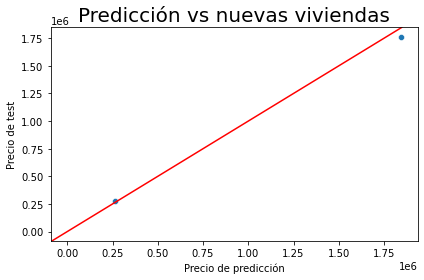

In [200]:
fig, ax = plt.subplots()
sns.scatterplot(x = y_new_pred, y = y_new, ax=ax)
ax.set_title('Predicción vs nuevas viviendas', fontsize=20)  
ax.set_xlabel('Precio de predicción')
ax.set_ylabel('Precio de test')
plt.axline([0,0],[1,1],color='red')
plt.tight_layout()

[Ir a inicio](#inicio)

<a id="deeplearning"></a>
## Deep Learning

In [10]:
from keras.models import Sequential
from keras.layers import Dense

In [4]:
data = np.load(os.path.join(DATA_PATH, 'features_selected.npz'), allow_pickle=True)
features_selected = data['features_selected']
features_selected

with open(os.path.join(DATA_PATH, 'X_train.df'), 'rb') as archivo_entrada:
    X_train = pickle.load(archivo_entrada)

with open(os.path.join(DATA_PATH, 'y_train.serie'), 'rb') as archivo_entrada:
    y_train = pickle.load(archivo_entrada)

with open(os.path.join(DATA_PATH, 'X_test.df'), 'rb') as archivo_entrada:
    X_test = pickle.load(archivo_entrada)

with open(os.path.join(DATA_PATH, 'y_test.serie'), 'rb') as archivo_entrada:
    y_test = pickle.load(archivo_entrada)

In [5]:
X_train2 = X_train[features_selected]
display(X_train2)
X_test2 = X_test[features_selected]
display(X_test2)

,exterior,distance,size,rooms,priceByArea,propertyType_flat,latitude,coddistrit_1,bathrooms,coddistrit_2,propertyType_chalet,codbar_3,codbar_5,hasParkingSpace
323,0,2035,26.0,1,3269,1,40.458198,0.0,1,-1.0,0,0.0,-1.0,0
2412,1,2845,262.0,5,3244,1,40.461711,0.0,4,-1.0,0,0.0,-1.0,1
5967,1,3464,63.0,1,3143,1,40.409648,0.0,1,-2.0,0,-1.0,-1.0,0
2464,0,3679,60.0,0,3750,0,40.406914,0.0,1,-2.0,0,-1.0,-1.0,0
2245,1,2893,52.0,2,3077,1,40.465474,0.0,1,-1.0,0,0.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1,8492,97.0,3,1598,1,40.389266,1.0,2,-2.0,0,-2.0,-1.0,0
5191,0,3261,413.0,6,2903,0,40.466469,0.0,4,-1.0,1,0.0,-1.0,1
5390,0,4020,103.0,4,4709,1,40.417931,1.0,2,-1.0,0,-1.0,-1.0,0
860,1,11288,75.0,2,3187,1,40.470882,1.0,2,-2.0,0,-2.0,-1.0,1


,exterior,distance,size,rooms,priceByArea,propertyType_flat,latitude,coddistrit_1,bathrooms,coddistrit_2,propertyType_chalet,codbar_3,codbar_5,hasParkingSpace
518,0,3694,51.0,2,2784,1,40.473224,-1.0,1,-1.0,0,-1.0,-1.0,0
6681,1,2499,404.0,5,10767,1,40.428922,0.0,6,-1.0,0,-2.0,-1.0,0
233,1,4684,39.0,0,4744,0,40.441719,1.0,1,-2.0,0,-1.0,-1.0,0
6928,1,2894,223.0,5,4036,1,40.436119,0.0,2,-1.0,0,-1.0,-1.0,1
5880,1,4899,93.0,2,6430,1,40.453535,1.0,2,-2.0,0,-1.0,-1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7203,1,10848,65.0,3,1669,1,40.343547,0.0,1,-2.0,0,-1.0,-1.0,0
7132,0,3603,37.0,1,2973,1,40.407978,0.0,1,-2.0,0,-1.0,-1.0,0
1515,1,3097,231.0,3,7143,0,40.427743,0.0,3,-1.0,0,-1.0,-1.0,0
216,0,8865,992.0,7,1764,0,40.469962,0.0,7,-1.0,1,0.0,-1.0,1


In [9]:
# Primero estandarizamos las variables a usar en los modelos
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

scaler.fit(X_train2)
X_train_scal = scaler.transform(X_train2)
X_test_scal = scaler.transform(X_test2)

y_train_scal = scaler2.fit_transform(y_train.values.reshape(-1, 1))

In [12]:
X_train_scal.shape[1:]

(14,)

In [56]:
model = Sequential()
model.add(Dense(input_shape = X_train_scal.shape[1:], units=14, activation='tanh'))
model.add(Dense(units=6,activation='tanh'))
model.add(Dense(units=1))

model.compile(loss = "mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 90        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train_scal,
                    y_train_scal,
                    batch_size=64,
                    epochs = 100,
                    validation_split = 0.2)

Epoch 1/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0168 - val_loss: 0.0076
Epoch 2/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 3/100
85/85 [==============================] - 0s 961us/step - loss: 0.0047 - val_loss: 0.0043
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.003 - 0s 969us/step - loss: 0.0037 - val_loss: 0.0035
Epoch 5/100
85/85 [==============================] - 0s 988us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/100
85/85 [==============================] - 0s 984us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/100
85/85 [==============================] - 0s 1ms/step - loss: 0.0

Epoch 78/100
85/85 [==============================] - 0s 1ms/step - loss: 3.8183e-04 - val_loss: 3.5744e-04
Epoch 79/100
85/85 [==============================] - 0s 1ms/step - loss: 3.7399e-04 - val_loss: 5.4633e-04
Epoch 80/100
85/85 [==============================] - 0s 1ms/step - loss: 3.8311e-04 - val_loss: 3.5227e-04
Epoch 81/100
85/85 [==============================] - 0s 1ms/step - loss: 3.4999e-04 - val_loss: 3.4424e-04
Epoch 82/100
85/85 [==============================] - 0s 1ms/step - loss: 3.3680e-04 - val_loss: 3.3596e-04
Epoch 83/100
85/85 [==============================] - 0s 1ms/step - loss: 3.3561e-04 - val_loss: 3.6131e-04
Epoch 84/100
85/85 [==============================] - 0s 1ms/step - loss: 3.2503e-04 - val_loss: 3.5704e-04
Epoch 85/100
85/85 [==============================] - 0s 1ms/step - loss: 3.2050e-04 - val_loss: 3.8104e-04
Epoch 86/100
85/85 [==============================] - 0s 986us/step - loss: 3.1286e-04 - val_loss: 2.9197e-04
Epoch 87/100
85/85 [======

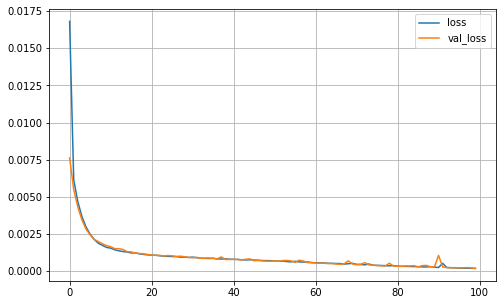

In [58]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()

plt.show()

In [59]:
pred_test = model.predict(X_test_scal)
pred_test2 = scaler2.inverse_transform(pred_test)
pred_test2 = pred_test2.ravel()

In [60]:
print("Desempeño del modelo con el conjunto de datos de test")
print("-----------------------------------------------------")
print("RMSE:",mean_squared_error(pred_test2,y_test, squared=False))
print("R2 score:", r2_score(pred_test2,y_test))

Desempeño del modelo con el conjunto de datos de test
-----------------------------------------------------
RMSE: 109129.94089971295
R2 score: 0.9826729979813575


In [61]:
test_df = pd.DataFrame({"y_test": y_test, "y_pred": np.rint(pred_test2)}, dtype=np.int64)
test_df['residuo'] = (test_df["y_test"] - test_df["y_pred"]).abs()
test_df = test_df.applymap(lambda x: '{:,}'.format(x).replace(',','.'))
test_df

,y_test,y_pred,residuo
518,142.000,-65.096,207.096
6681,4.350.000,4.161.025,188.975
233,185.000,179.039,5.961
6928,900.000,915.960,15.960
5880,598.000,599.086,1.086
...,...,...,...
7203,108.500,56.421,52.079
7132,110.000,70.517,39.483
1515,1.650.000,1.678.044,28.044
216,1.750.000,1.962.478,212.478


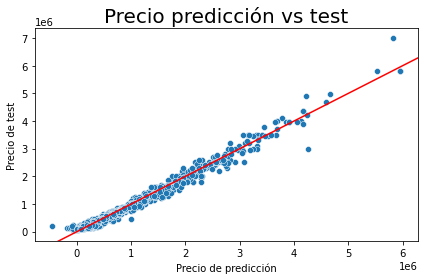

In [62]:
fig, ax = plt.subplots()
sns.scatterplot(x = pred_test2, y = y_test, ax=ax)
ax.set_title('Precio predicción vs test', fontsize=20)  
ax.set_xlabel('Precio de predicción')
ax.set_ylabel('Precio de test')
plt.axline([0,0],[1,1],color='red')
plt.tight_layout()

In [63]:
model.save(os.path.join(MODELS_PATH, 'idealista_model.h5'))

[Ir a inicio](#inicio)

<a id="predict_new_dl"></a>
#### Predecir nuevas viviendas con el modelo de Deep Learning

In [9]:
import keras.models

In [3]:
nuevas_viviendas_df = pd.read_csv(os.path.join(DATA_PATH, 'nuevas_viviendas_df.csv'))
nuevas_viviendas_df

,price,exterior,distance,size,rooms,priceByArea,propertyType_flat,latitude,coddistrit_1,bathrooms,coddistrit_2,propertyType_chalet,codbar_3,codbar_5,hasParkingSpace
0,275000,0,2447.048747,93.0,3.0,2957,1,40.395667,1.0,1.0,-1.0,0,0.0,-1.0,0
1,1760000,1,6435.075439,394.0,6.0,4467,0,40.451295,0.0,5.0,-2.0,1,-1.0,-1.0,0


In [4]:
with open(os.path.join(MODELS_PATH, 'minmaxscaler.scaler'), 'rb') as archivo_entrada:
    scaler = pickle.load(archivo_entrada)

C:\ProgramData\Anaconda3\envs\deeplearningOK\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [14]:
with open(os.path.join(DATA_PATH, 'y_train.serie'), 'rb') as archivo_entrada:
    y_train = pickle.load(archivo_entrada)

In [6]:
X_new = nuevas_viviendas_df.drop(columns=["price"])
y_new = nuevas_viviendas_df["price"].values

In [7]:
X_new_scal = scaler.transform(X_new)
X_new_scal

array([[0.        , 0.15538887, 0.03553512, 0.15      , 0.17652596,
        1.        , 0.3204432 , 1.        , 0.05      , 1.        ,
        0.        , 1.        , 1.        , 0.        ],
       [1.        , 0.41369748, 0.16137124, 0.3       , 0.2858591 ,
        0.        , 0.5934897 , 0.5       , 0.25      , 0.5       ,
        1.        , 0.66666667, 1.        , 0.        ]])

In [15]:
scaler2 = MinMaxScaler()

y_train_scal = scaler2.fit_transform(y_train.values.reshape(-1, 1))

In [11]:
model = keras.models.load_model(os.path.join(MODELS_PATH, 'idealista_model.h5'))

In [17]:
pred_new = model.predict(X_new_scal)
pred_new2 = scaler2.inverse_transform(pred_new)
pred_new2 = pred_new2.ravel()

In [18]:
prediccion_new_df = pd.DataFrame({"Precio": y_new, "Prediccion": np.rint(pred_new2)}, dtype=np.int64)
prediccion_new_df['Residuo'] = (prediccion_new_df["Precio"] - prediccion_new_df["Prediccion"]).abs()

In [19]:
prediccion_new_df.applymap(lambda x: '{:,}'.format(x).replace(',','.'))

,Precio,Prediccion,Residuo
0,275.000,352.819,77.819
1,1.760.000,1.938.534,178.534


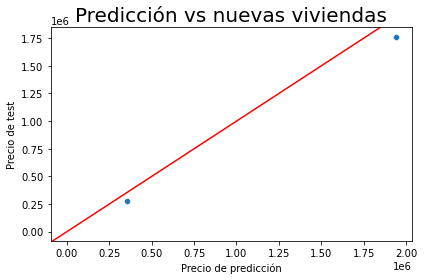

In [21]:
fig, ax = plt.subplots()
sns.scatterplot(x = pred_new2, y = y_new, ax=ax)
ax.set_title('Predicción vs nuevas viviendas', fontsize=20)  
ax.set_xlabel('Precio de predicción')
ax.set_ylabel('Precio de test')
plt.axline([0,0],[1,1],color='red')
plt.tight_layout()

Peores predicciones  que con DecisionTreeRegressor.

[Ir a inicio](#inicio)